# Examples of inequality constraints on a local region

## Sum of source term = 0 outside of the source support

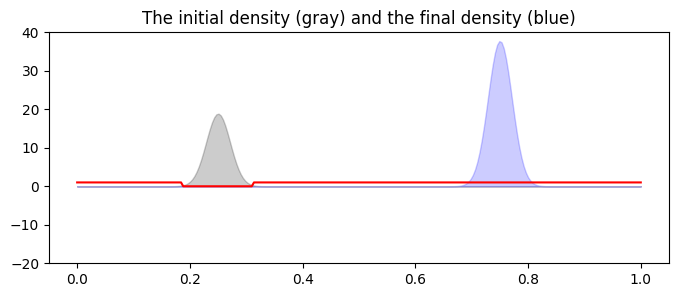

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / (256 * 2)

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 40)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
H = np.ones((K,))
H[48:80] = 0
plt.plot(X, H, color="r", label="H")
plt.show()

In [5]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.stack([H] * T, axis=0)  # Repeating H for each time step
time = np.array([(i+0.5)/T for i in range(0,T)])

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 0.5/np.pi

# Wasserstein-Fisher-Rao
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# Greater than 1
Hs = [np.zeros((T, K)), np.zeros((T, K)), H]
GL = np.zeros((T,))
GU = np.zeros((T,))
x, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


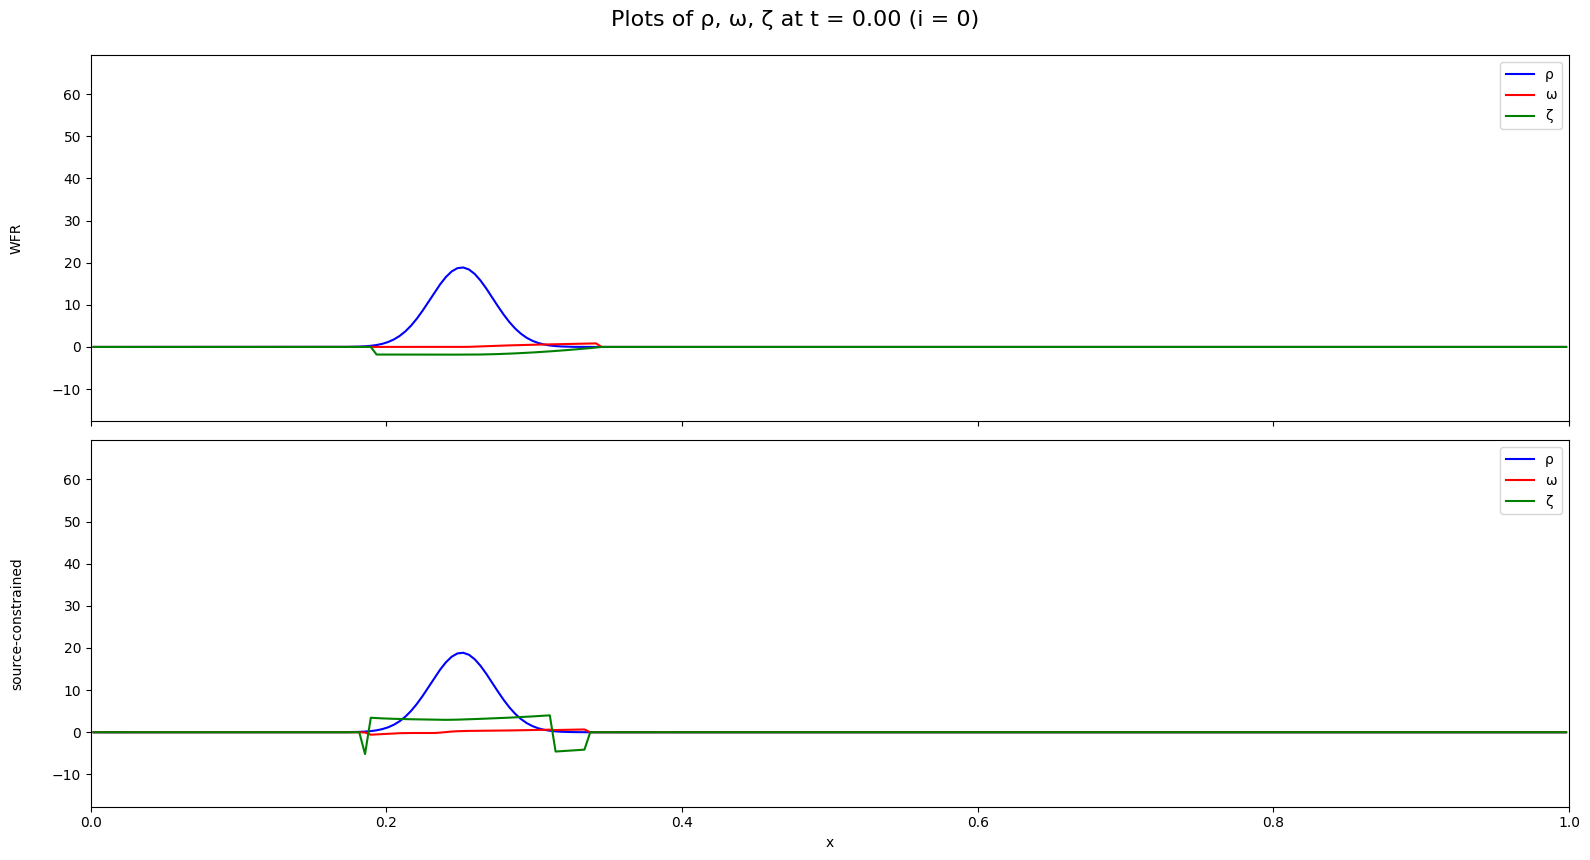

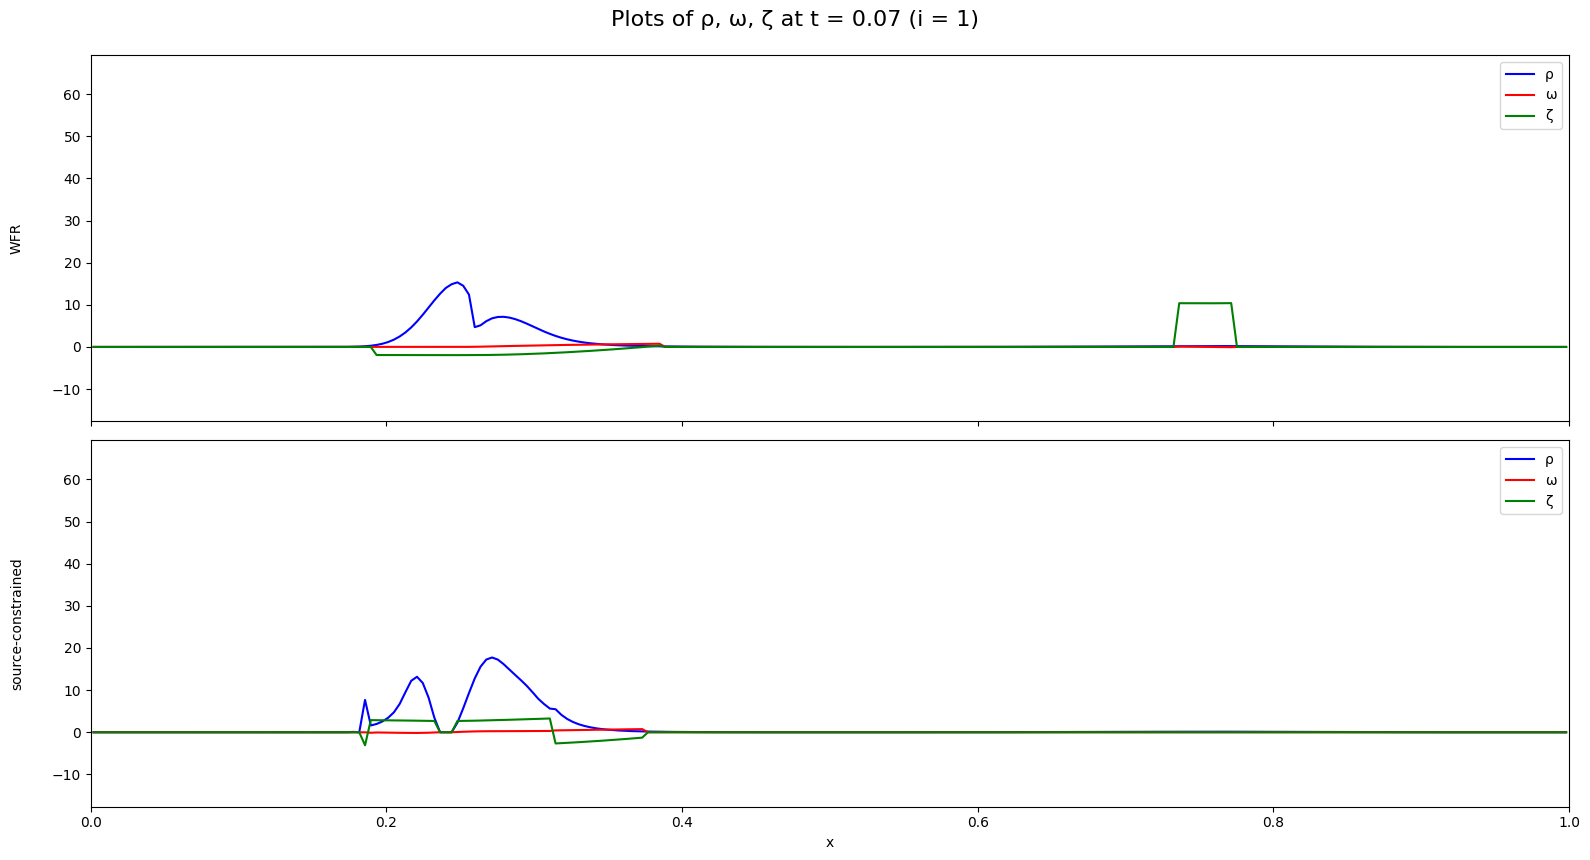

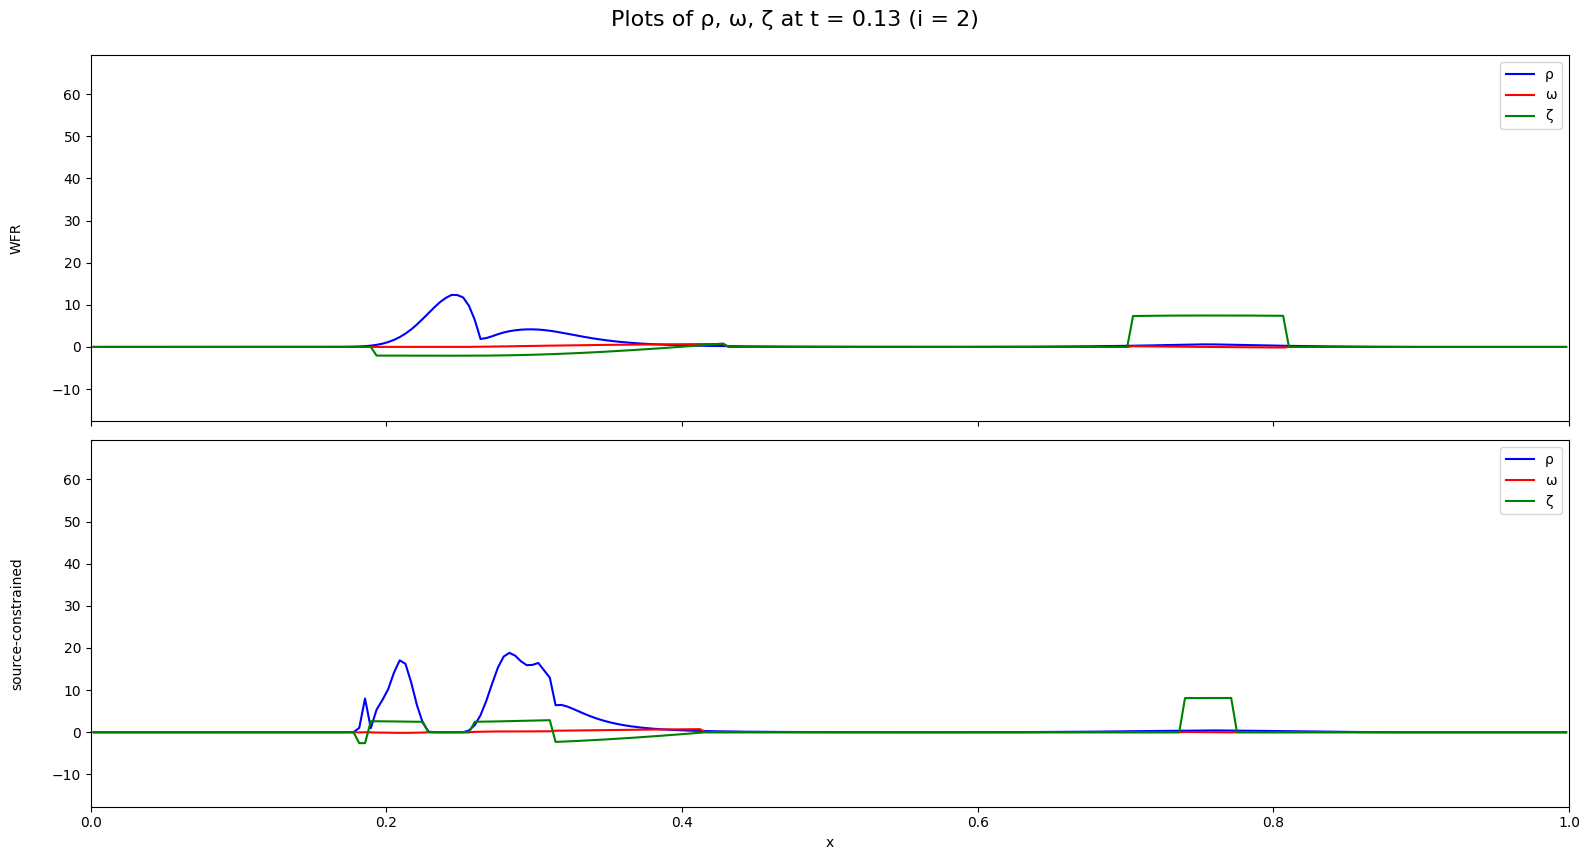

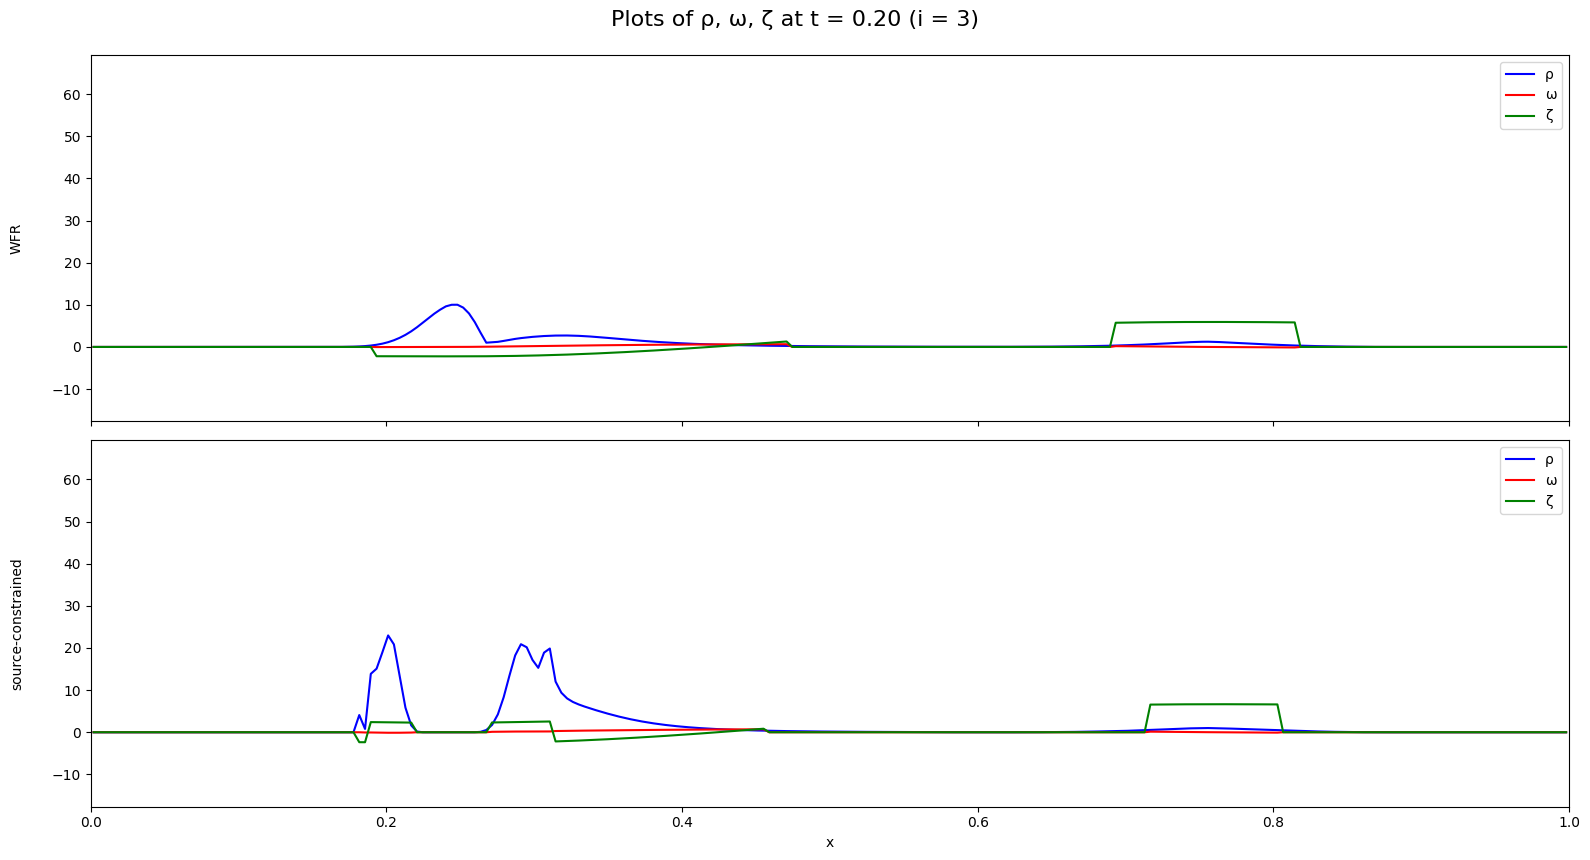

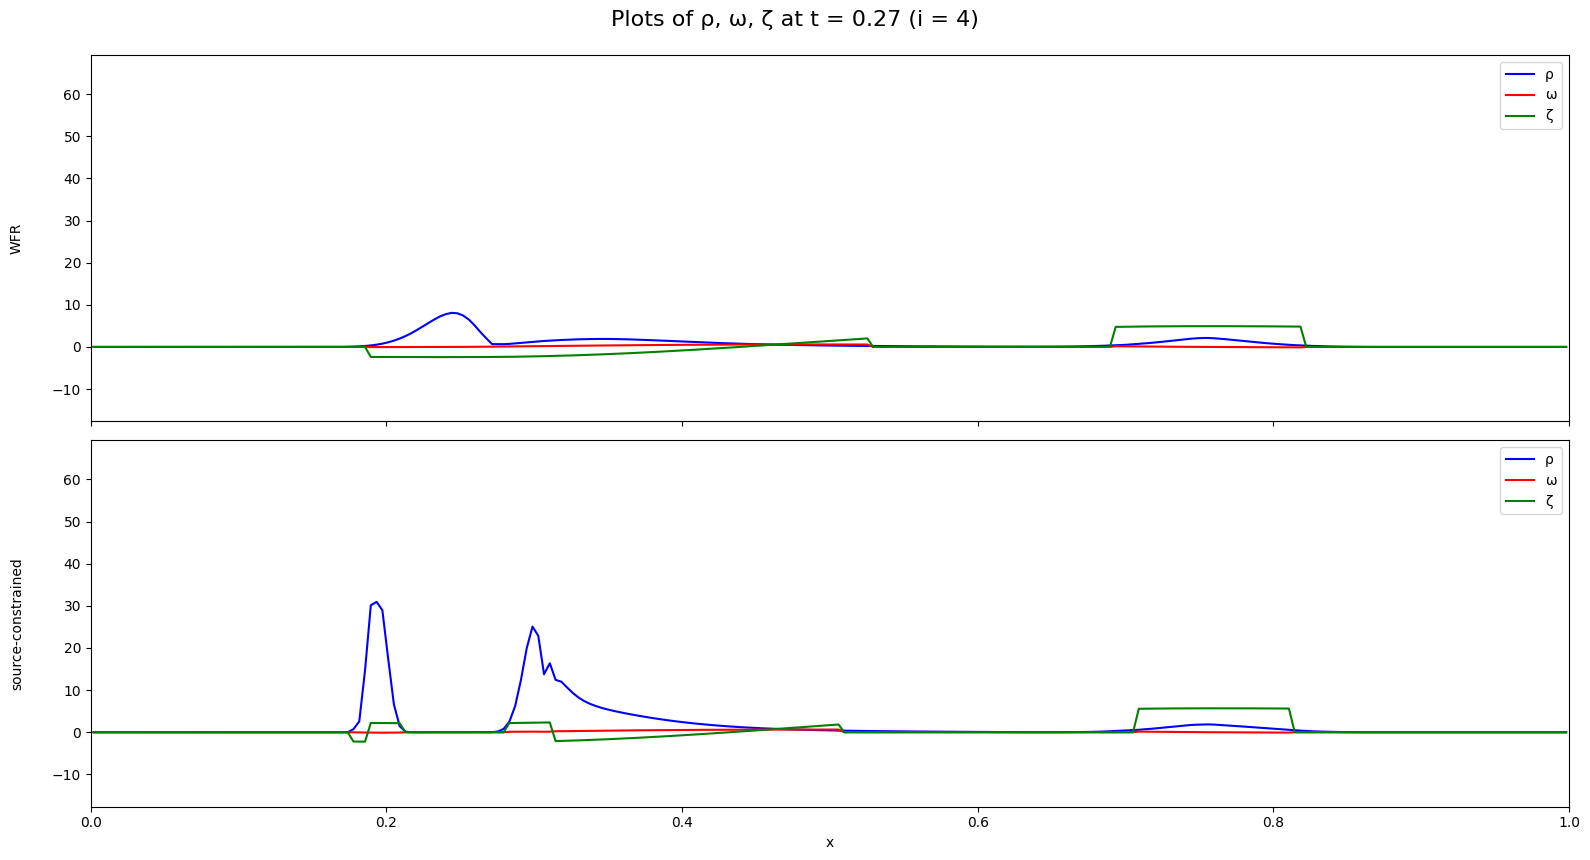

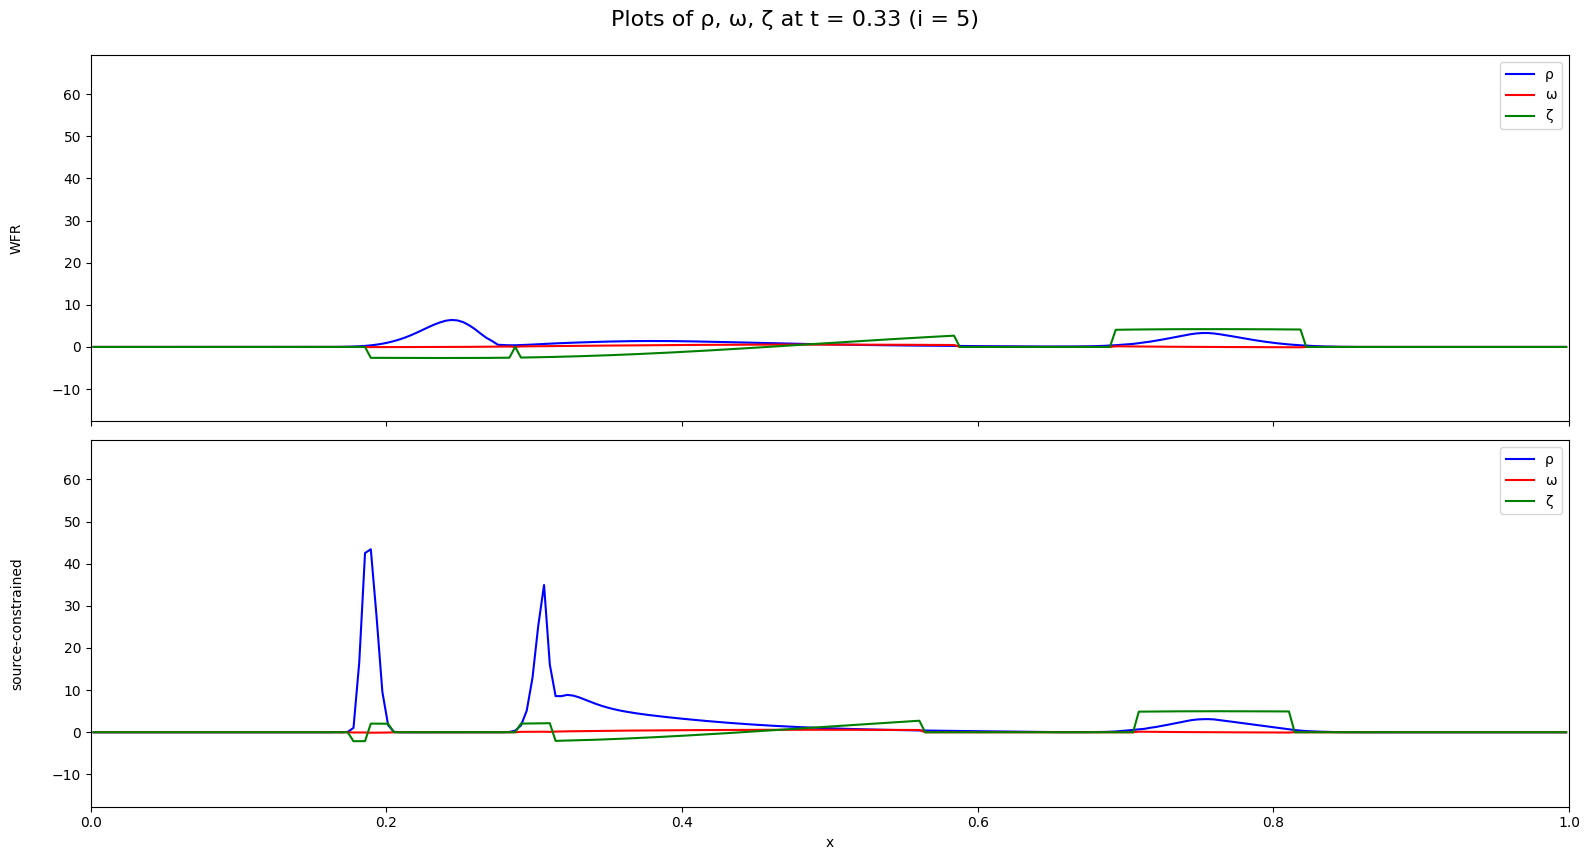

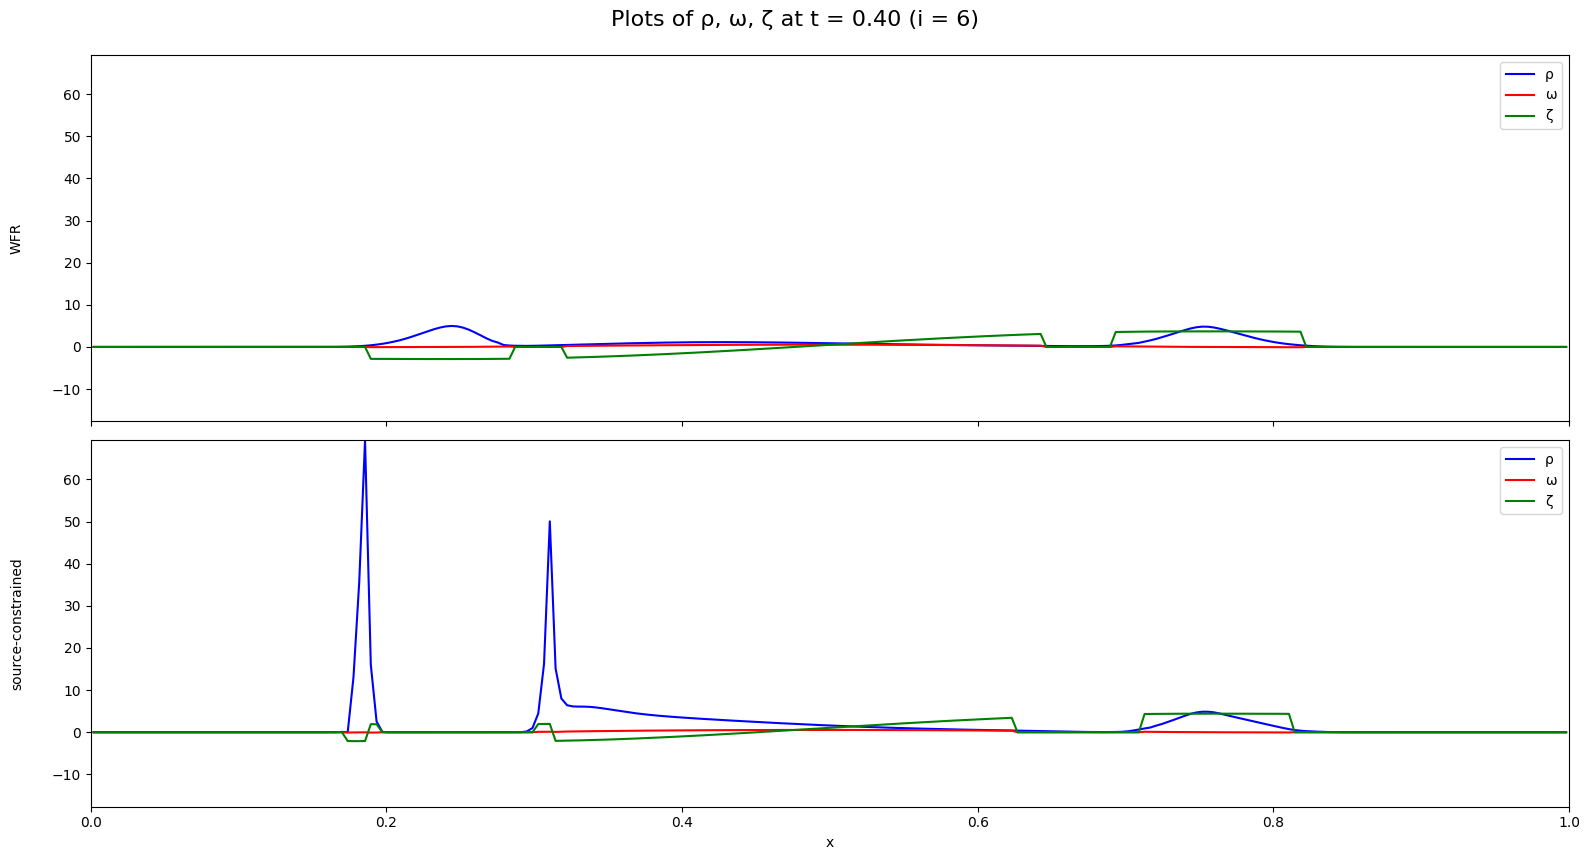

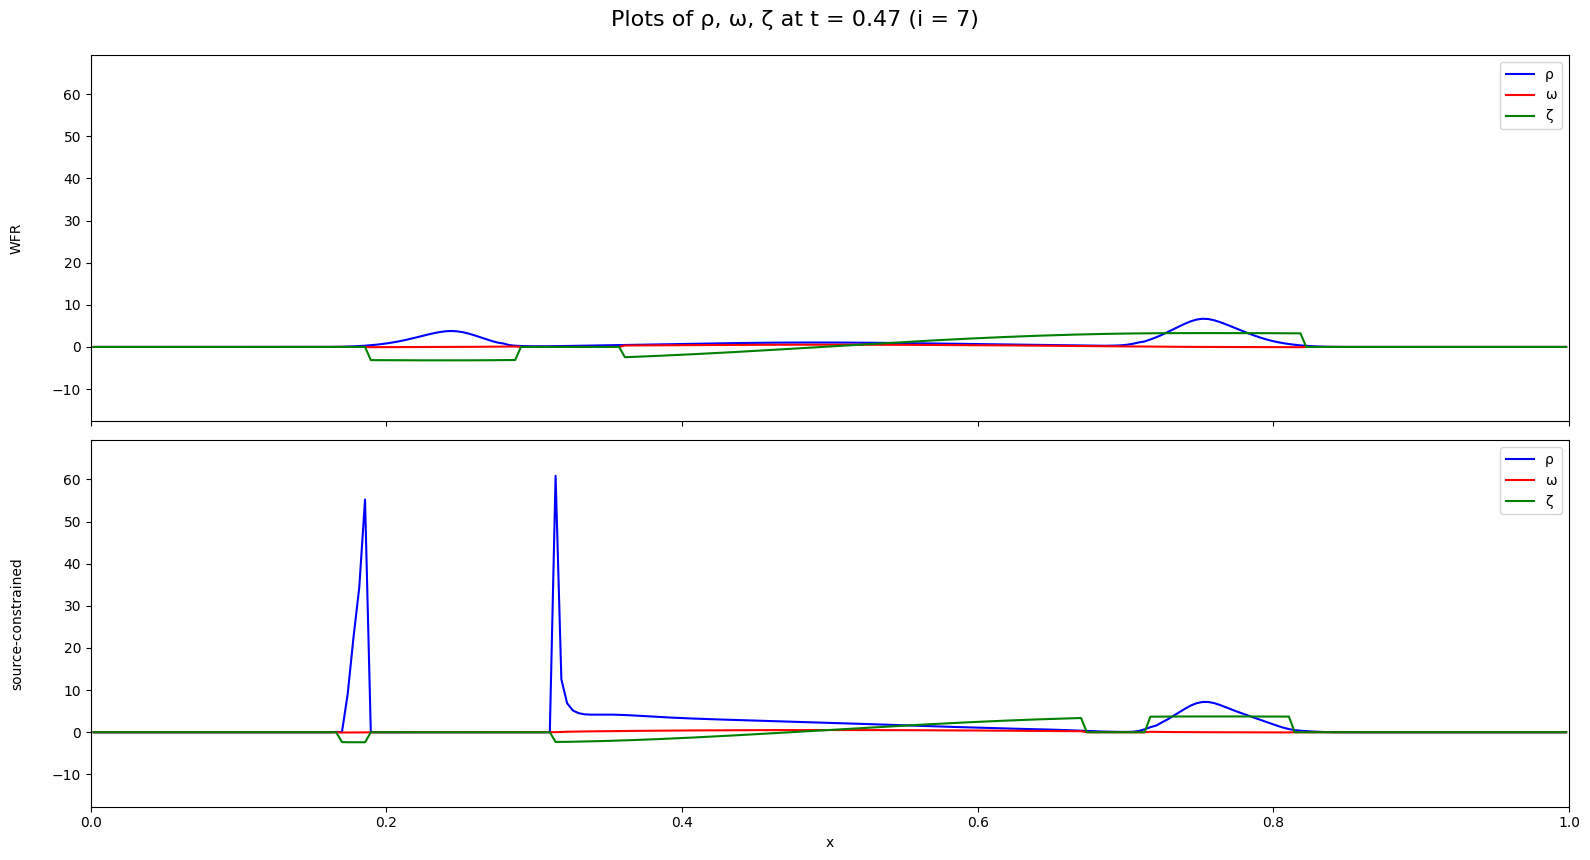

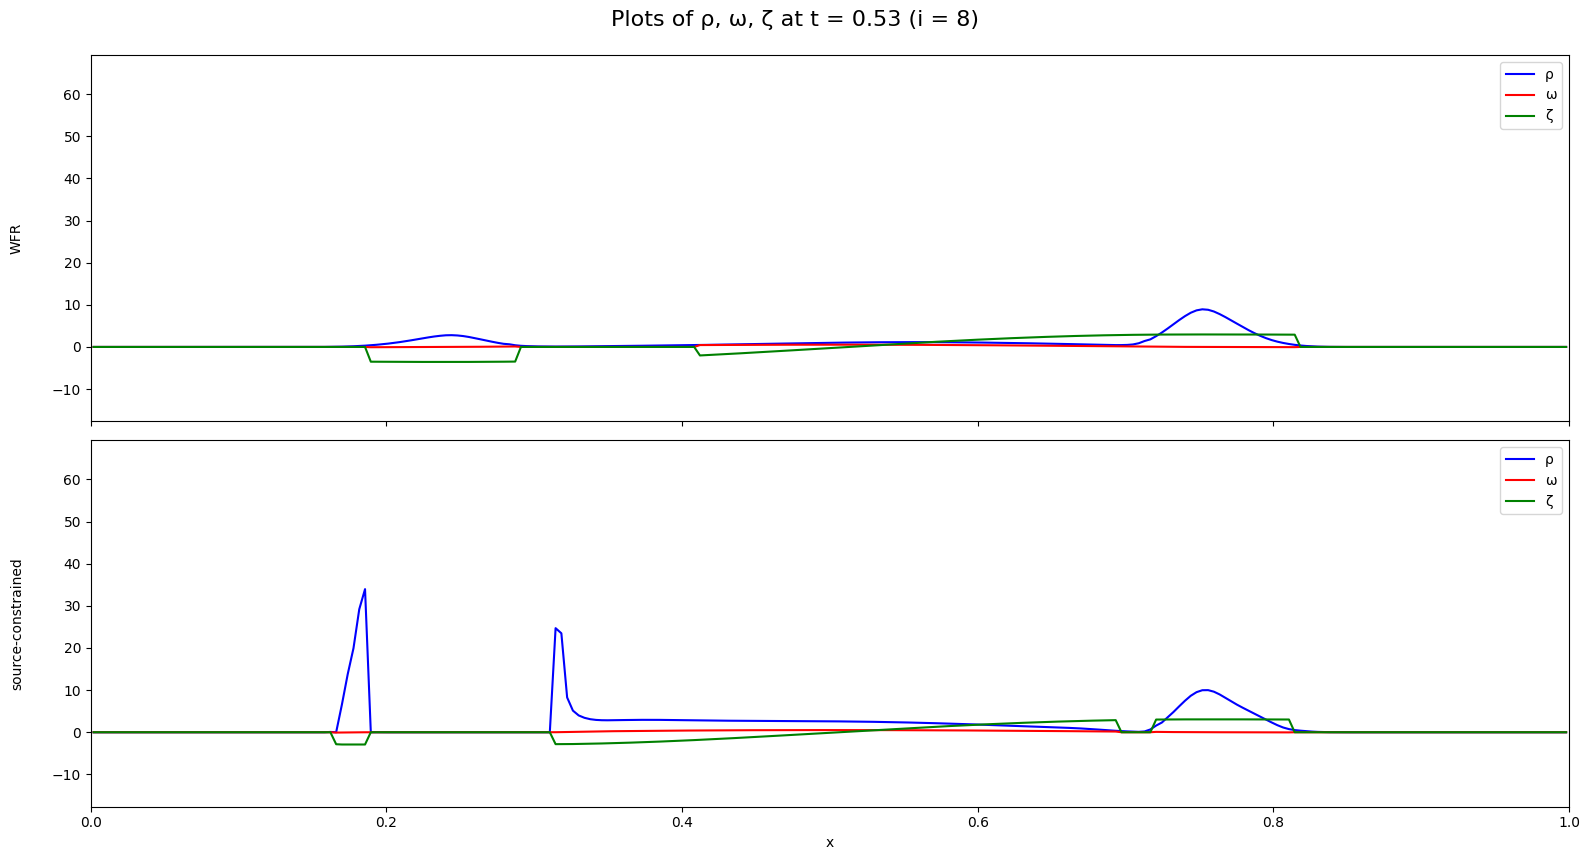

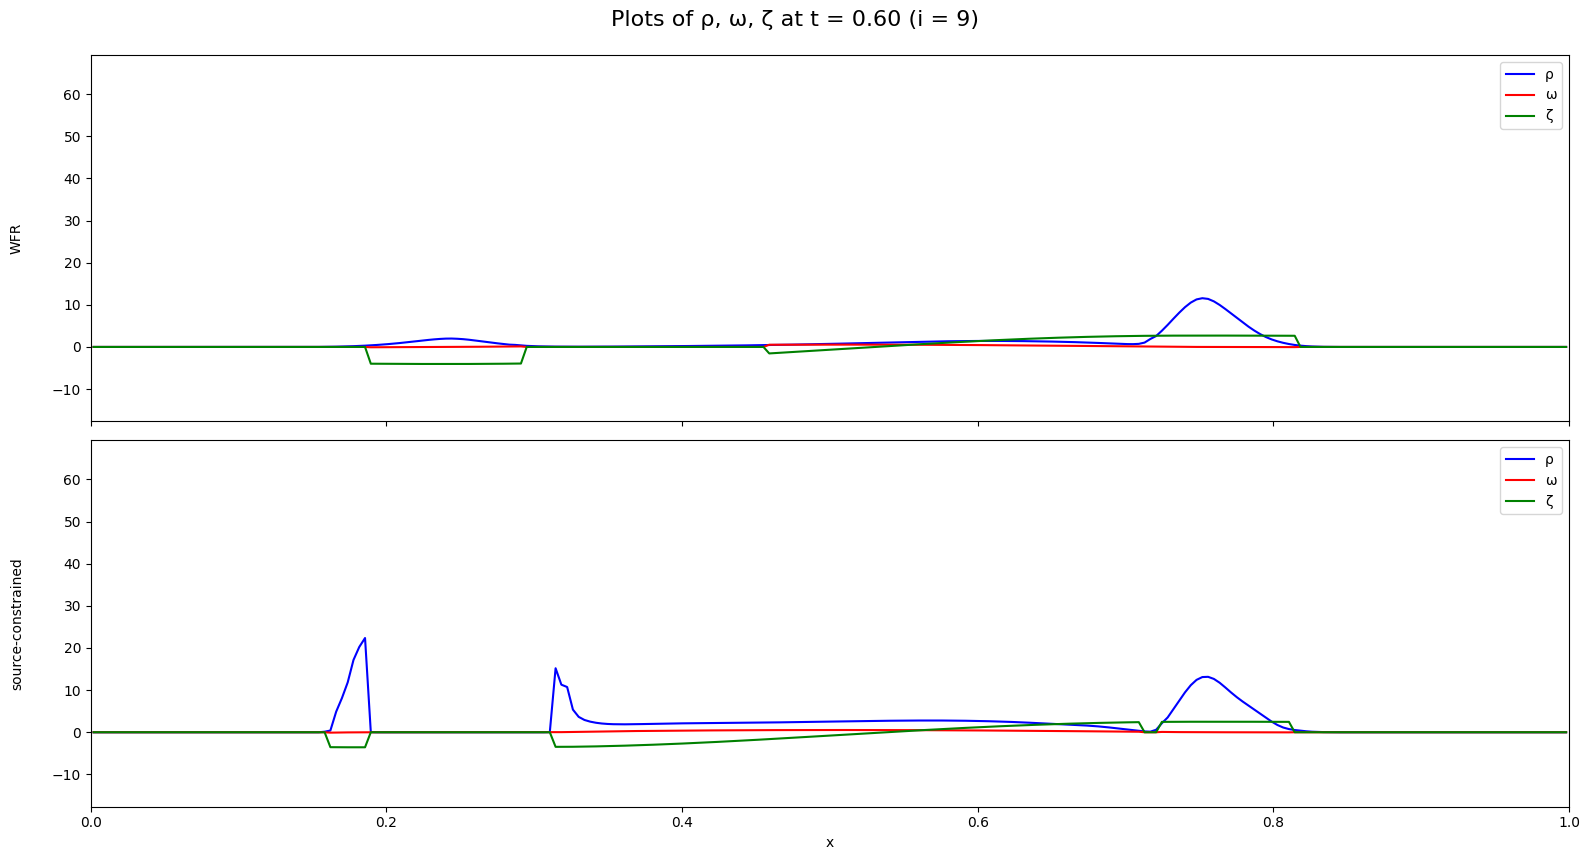

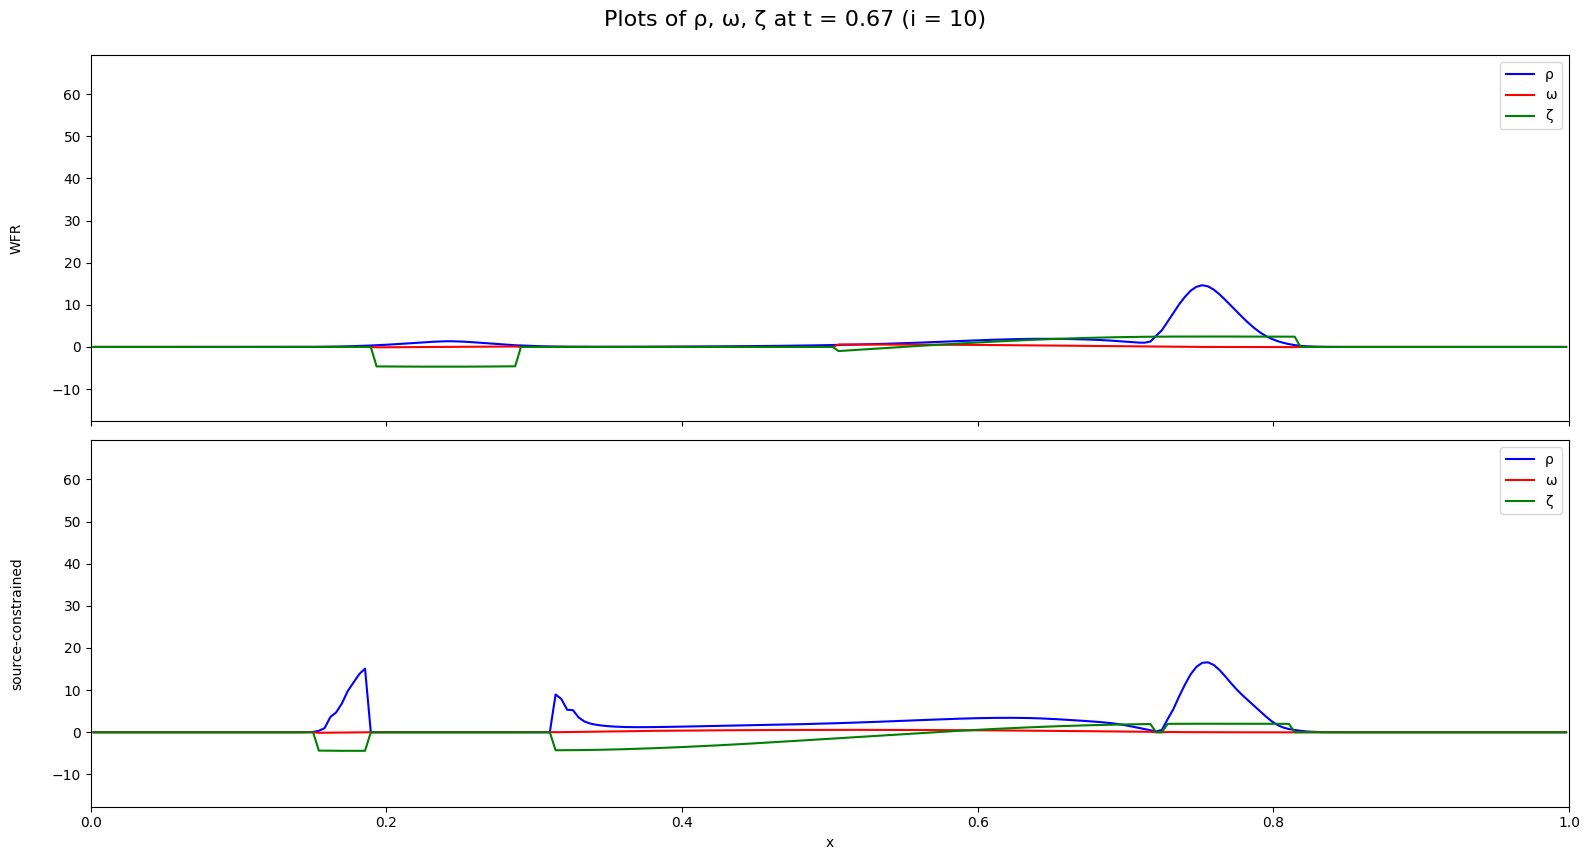

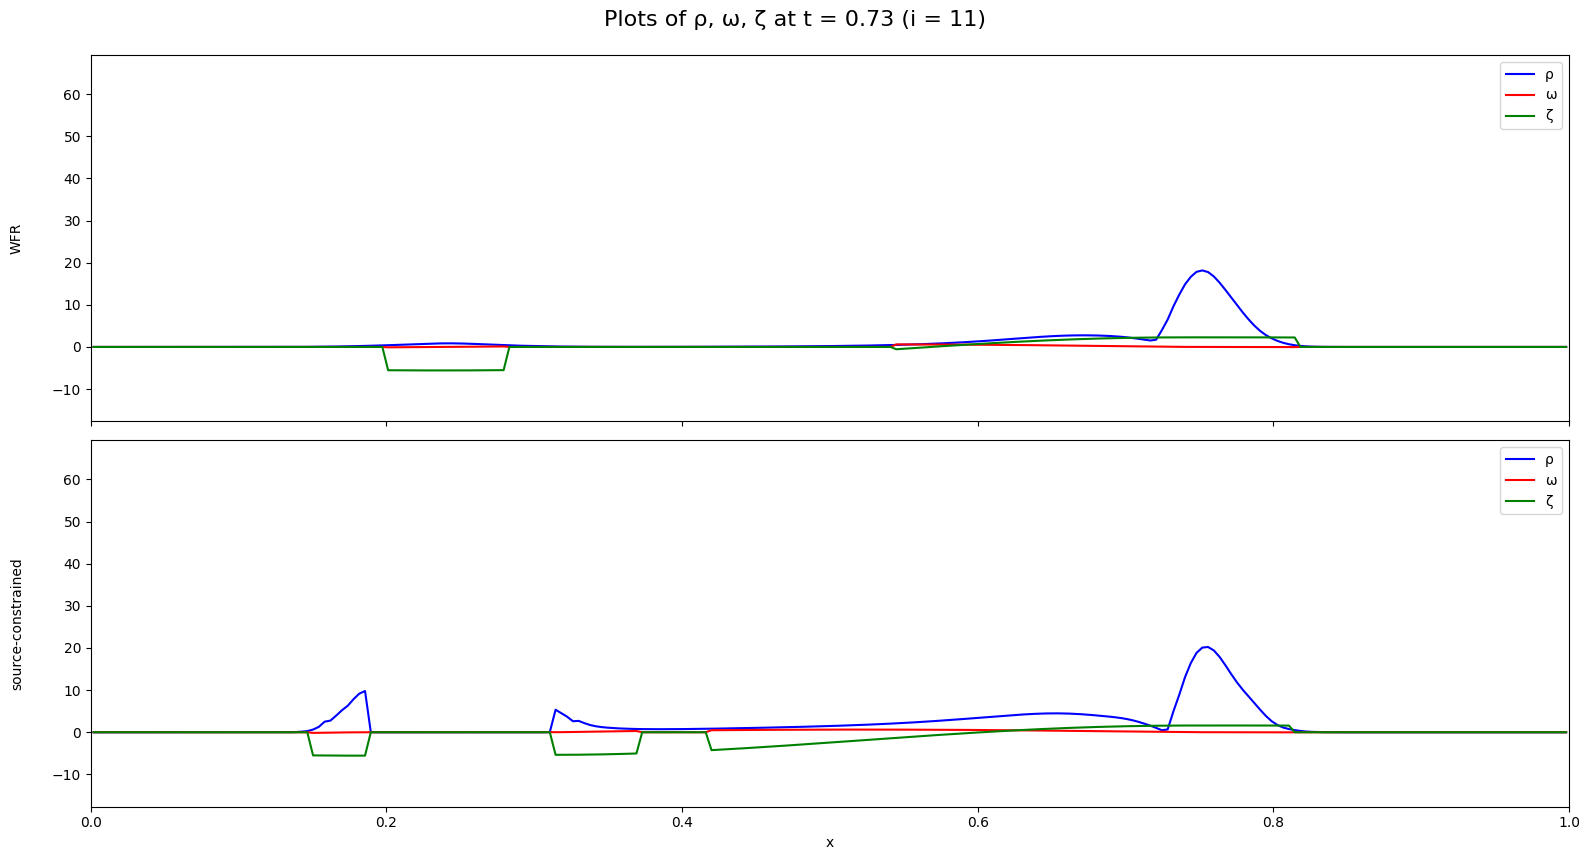

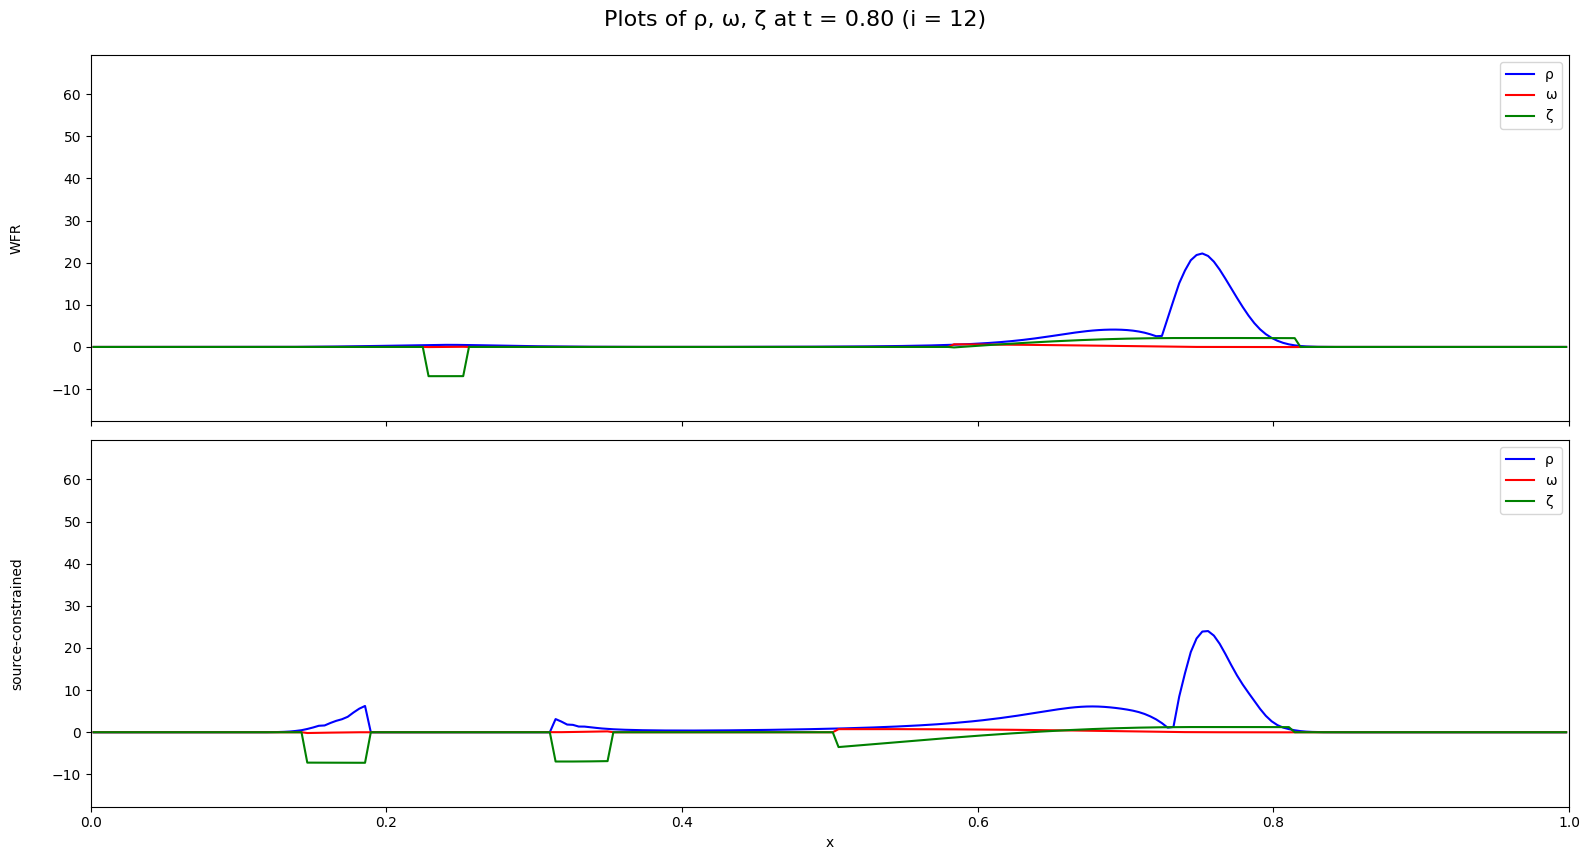

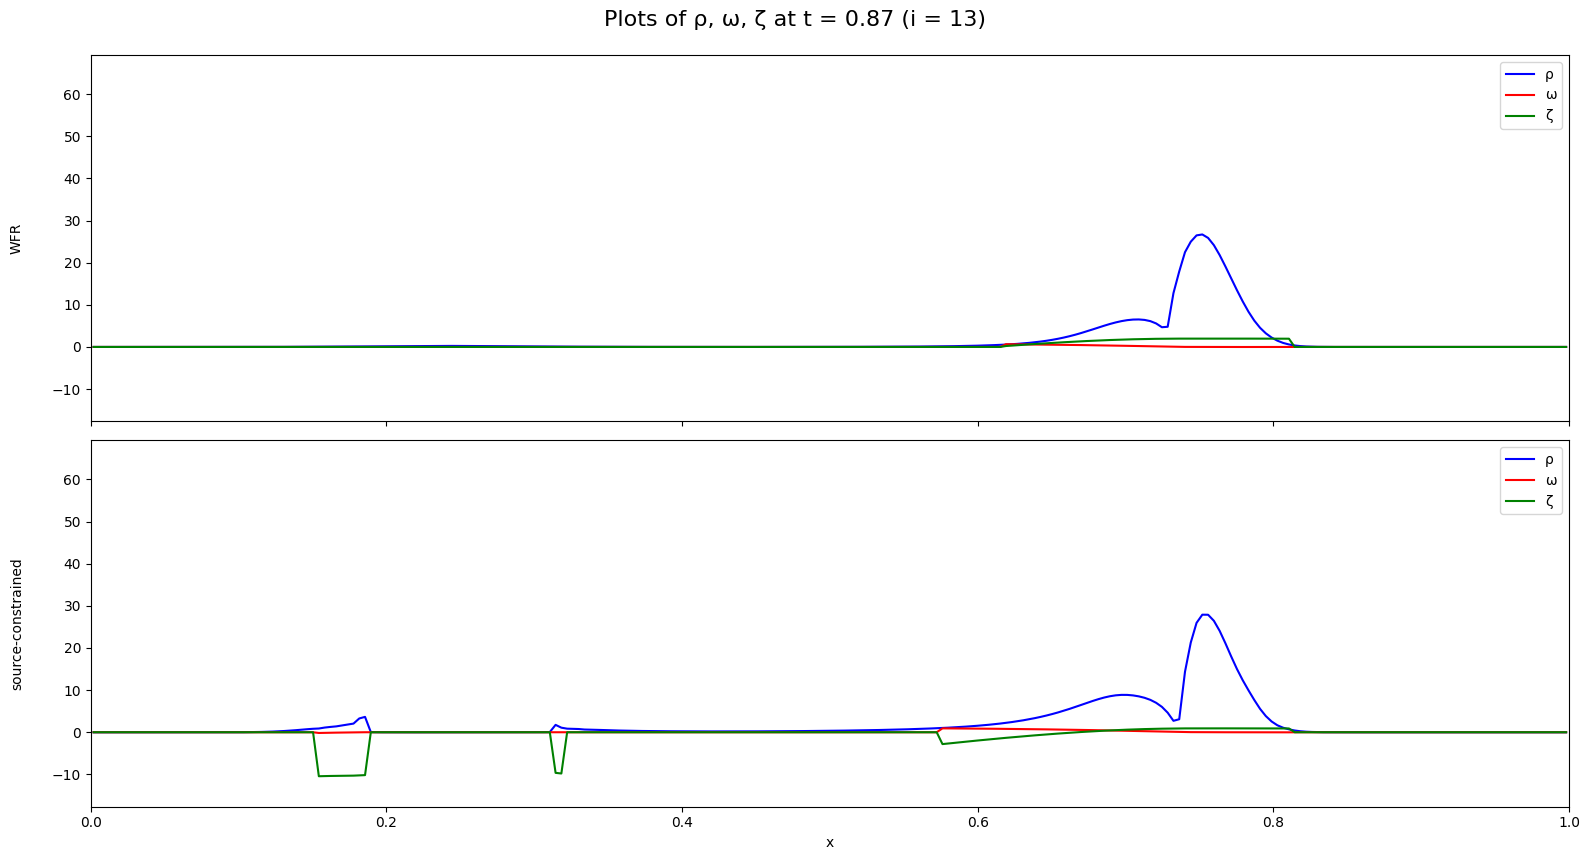

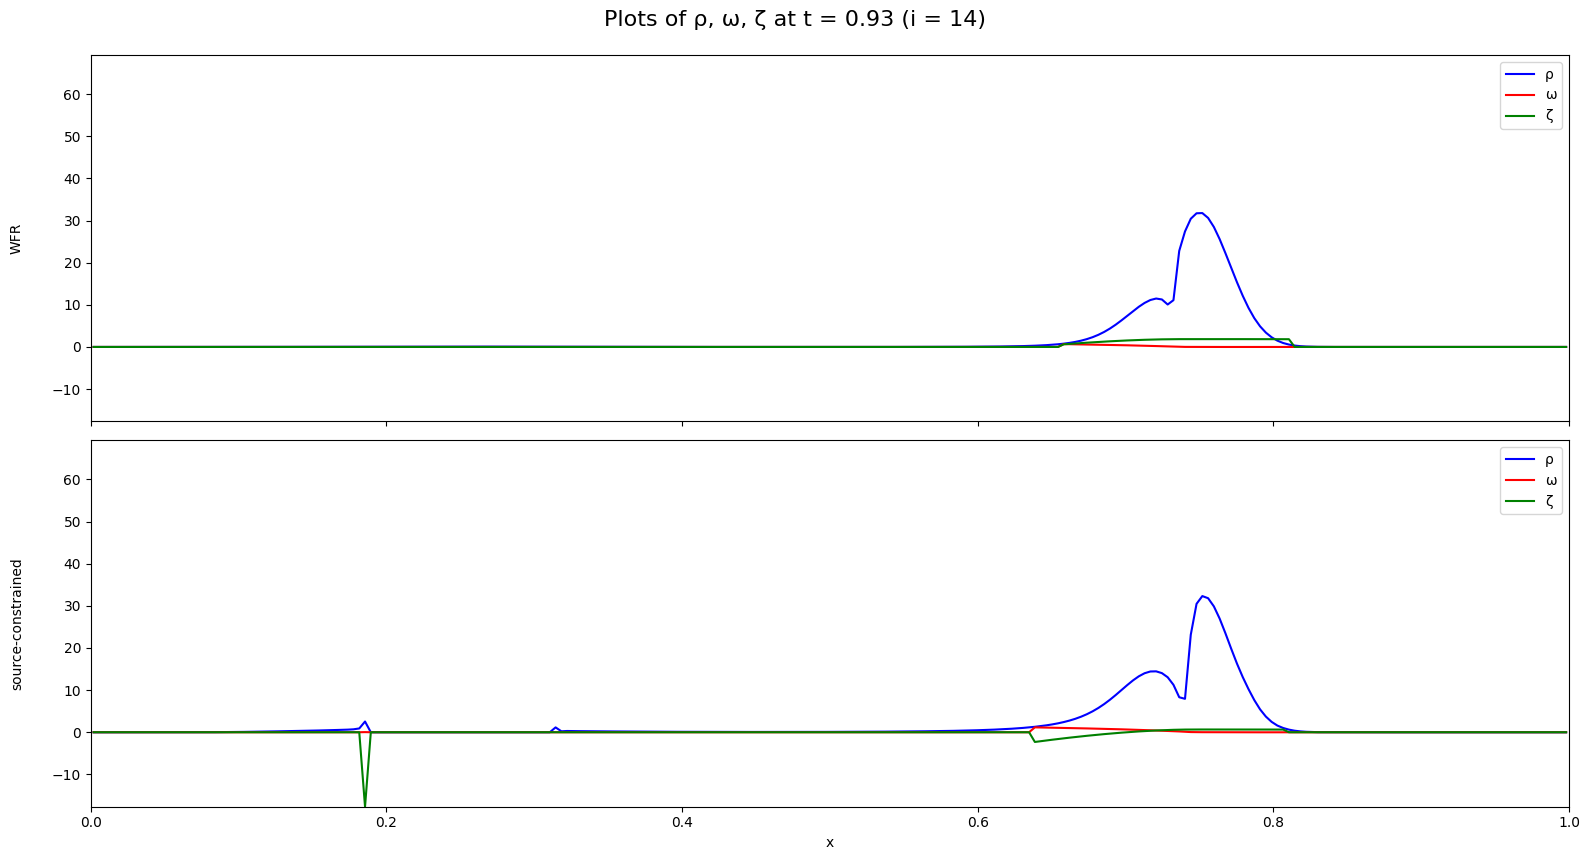

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Ds = []
vs = []
gs = []
for x in xs:
    Ds.append(x.U.D[0])
    v, g = speed_and_growth(x.V, 100)
    vs.append(v[0])
    gs.append(g)

# Time and space grids
t = np.linspace(0, 1, T + 1)             # t_i = i/15
x_grid = (np.arange(256) + 0.5) / 256 # x_j = (j+0.5)/256

# Row labels
row_labels = ["WFR", "source-constrained"]

# Indices of time to plot
time_indices = list(range(T))

# -----------------------------------------------------------
# 2) Compute global min/max for each row across *all times*
#    and across D, v, and g. This ensures fixed y-limits.
# -----------------------------------------------------------
num_rows = len(row_labels)
min_vals = float('inf')
max_vals = float('-inf')

for row in range(num_rows):
    # Flatten or just use min/max on the entire 16x256 data
    # across D, v, and g for row 'row'
    row_min = min(Ds[row].min(), vs[row].min(), gs[row].min())
    row_max = max(Ds[row].max(), vs[row].max(), gs[row].max())
    
    min_vals = min(row_min, min_vals)
    max_vals = max(row_max, max_vals)

# -----------------------------------------------------------
# 3) Loop through the selected time indices and plot
# -----------------------------------------------------------
for i in time_indices:
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 9), sharex=True)
    
    # Main figure title
    fig.suptitle(f"Plots of ρ, ω, ζ at t = {t[i]:.2f} (i = {i})", fontsize=16, y=0.95)

    for row in range(num_rows):
        ax = axes[row]
        
        # Plot all three on the same axes
        ax.plot(x_grid, Ds[row][i, :], label='ρ', color='blue')
        ax.plot(x_grid, vs[row][i, :], label='ω', color='red')
        ax.plot(x_grid, gs[row][i, :], label='ζ', color='green')
        
        # Set fixed y-limits for this row
        ax.set_ylim([min_vals, max_vals])
        
        # Set x-limits if desired (0 to 1 here)
        ax.set_xlim([0, 1])

        # Label the y-axis to indicate the row
        ax.set_ylabel(row_labels[row], rotation=90, labelpad=20)
        
        # Show legend in each subplot
        ax.legend(loc='best')
    
    # Label the x-axis on the bottom subplot
    axes[-1].set_xlabel("x")
    
    # Final layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

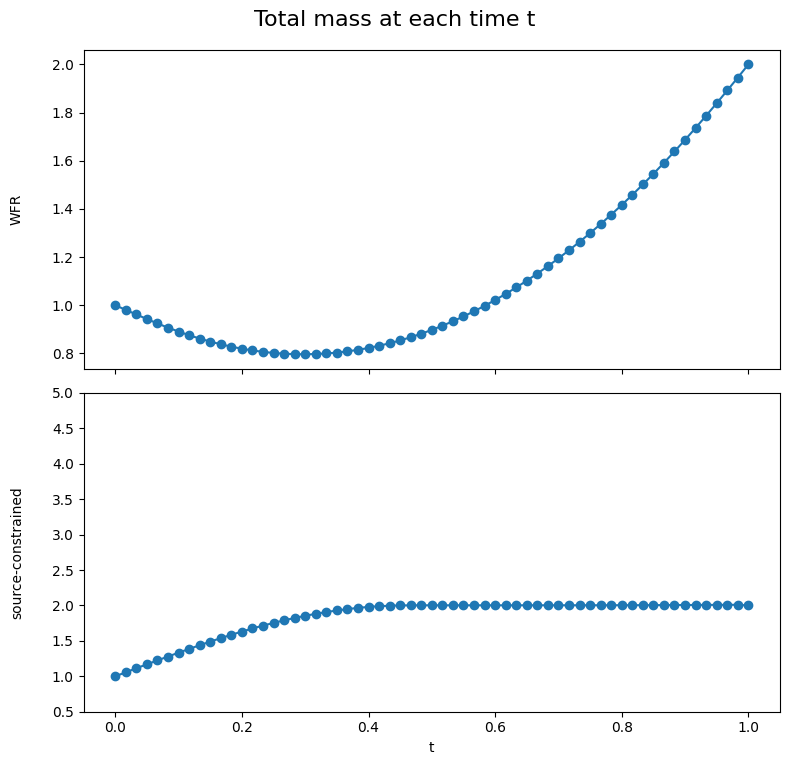

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)

fig.suptitle("Total mass at each time t", fontsize=16, y=0.95)

for row in range(2):
    # sum across columns (axis=1) => shape becomes (16,) for each element
    sum_over_x = np.sum(Ds[row], axis=1) / 256  # sums each row of Ds[row]
    if row == 1:
        axes[row].set_ylim(0.5, 5)
    axes[row].plot(t, sum_over_x, marker='o', label="Total mass")
    axes[row].set_ylabel(row_labels[row], rotation=90, labelpad=20)
    
    # Optionally add a legend
    #axes[row].legend(loc='best')

axes[-1].set_xlabel("t")
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


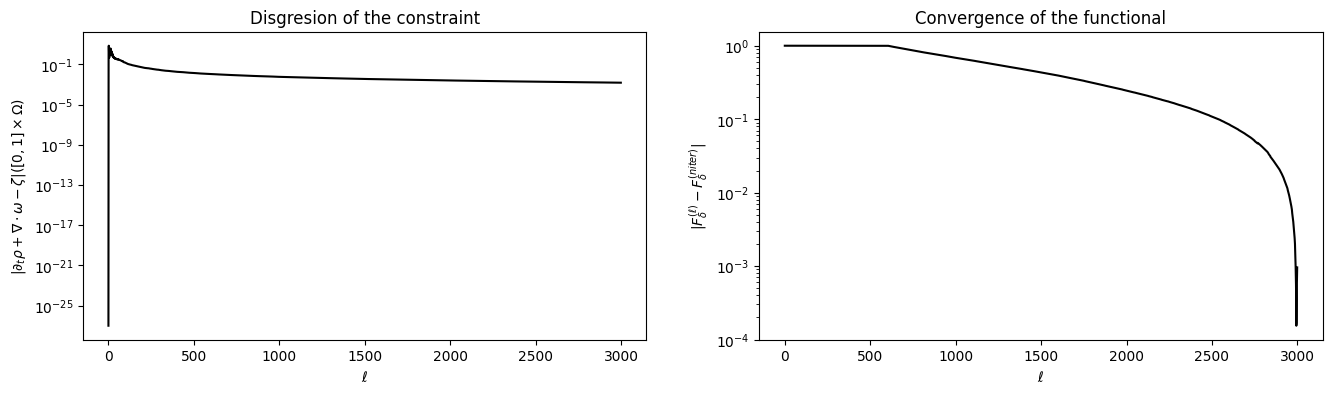

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(1, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.show()

# total mass constraint in the middle

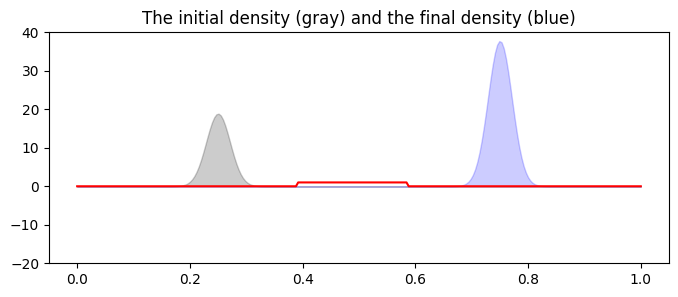

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / (256 * 2)

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 40)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
H = np.zeros((K,))
H[100:150] = 1.0
plt.plot(X, H, color="r", label="H")
plt.show()

In [ ]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.stack([H] * T, axis=0)  # Repeating H for each time step
time = np.array([(i+0.5)/T for i in range(0,T)])

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 2.0

# Wasserstein-Fisher-Rao
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# Greater than 1
Hs = [H, np.zeros((T, K)), np.zeros((T, K))]
GL = np.zeros((T,))
GU = np.ones((T,)) * 0.5
x, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


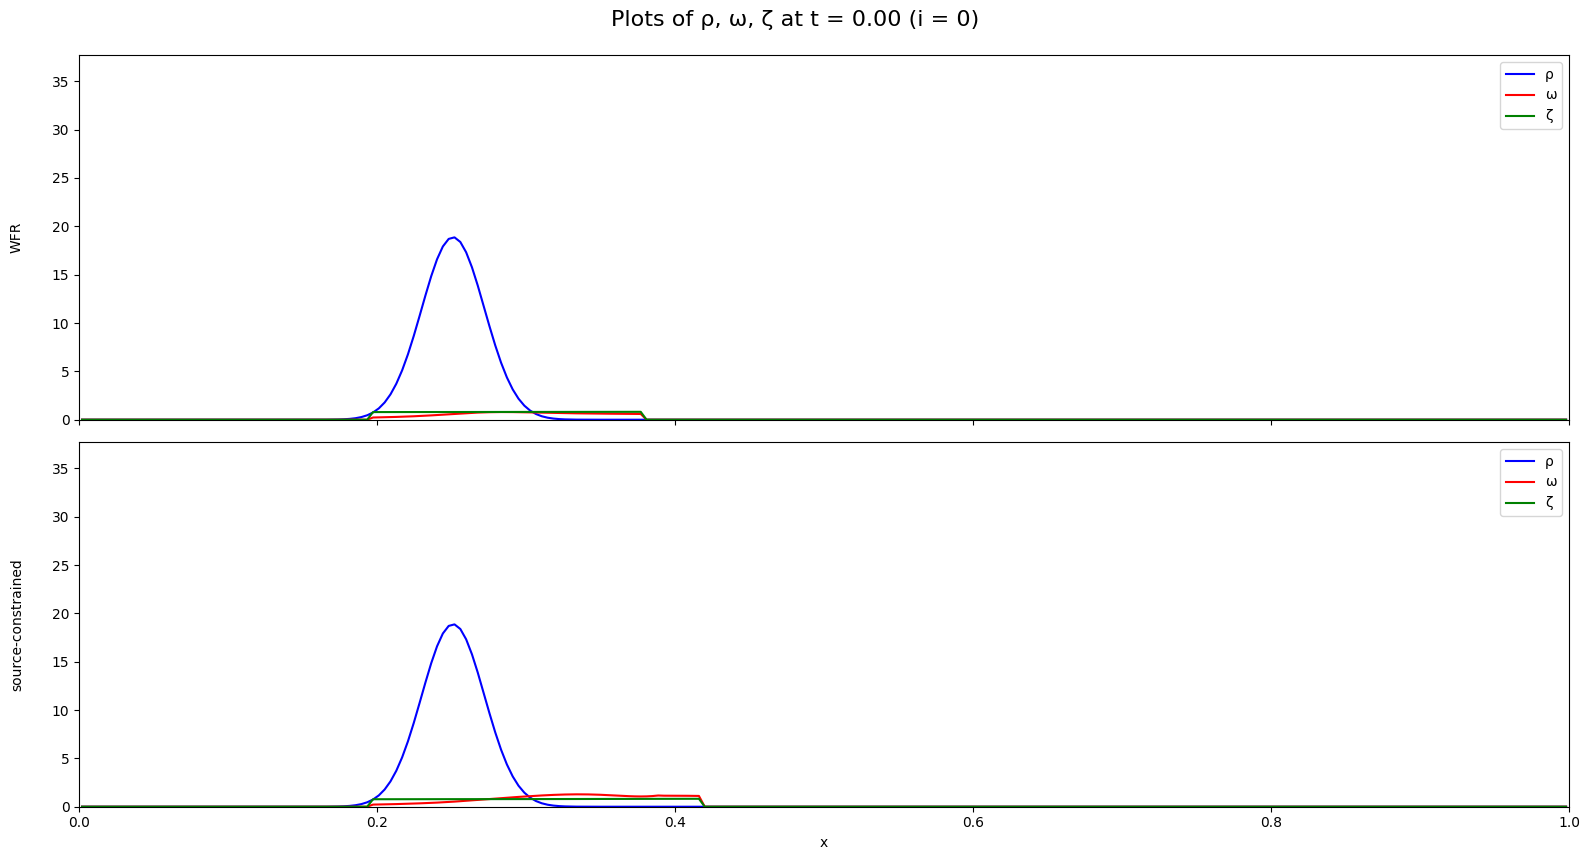

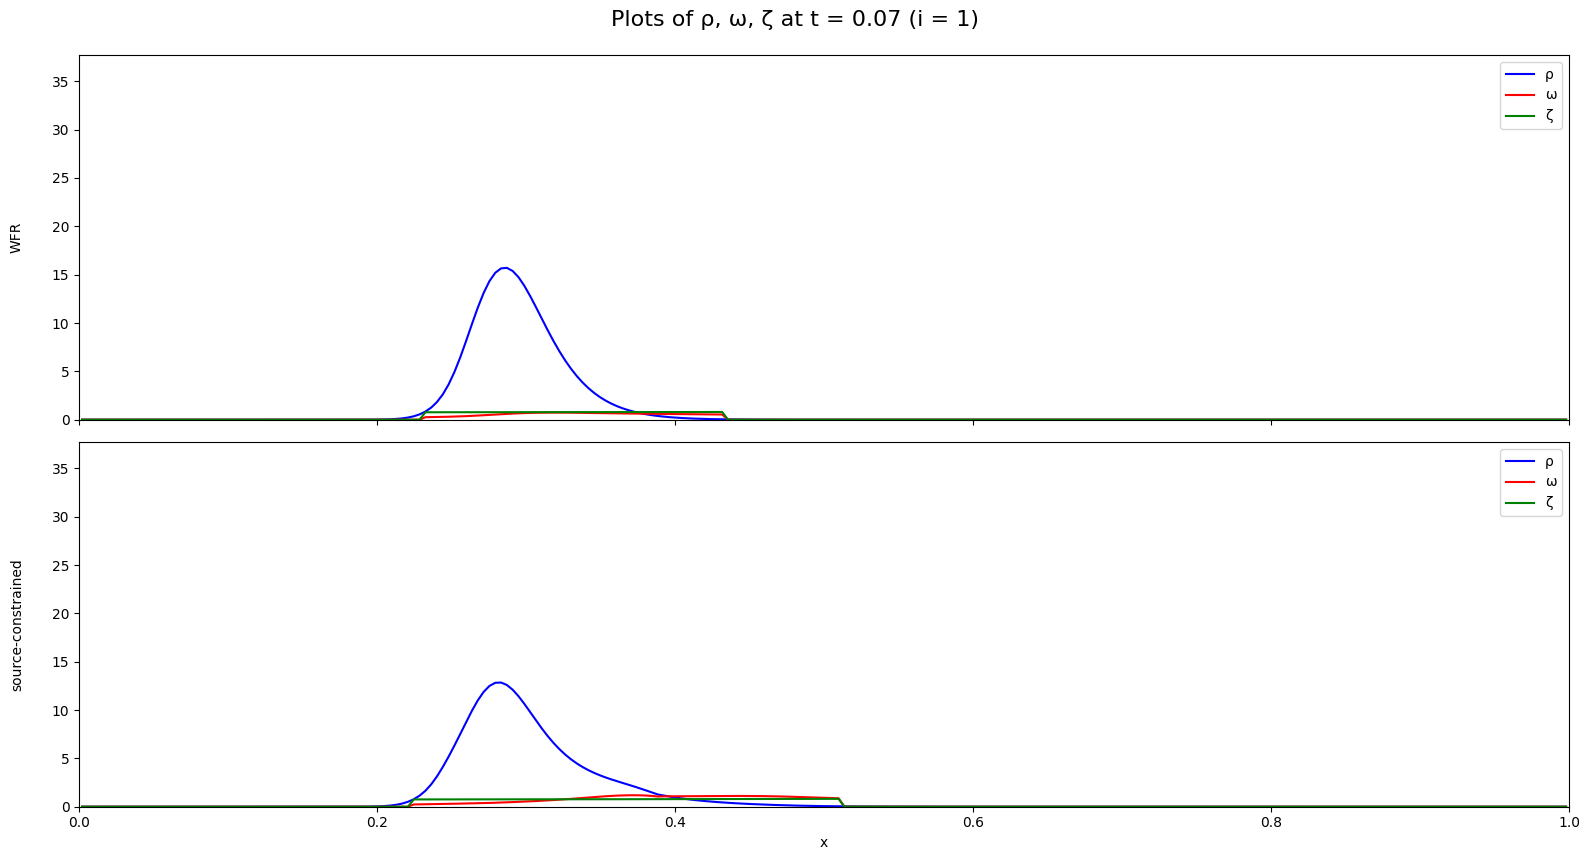

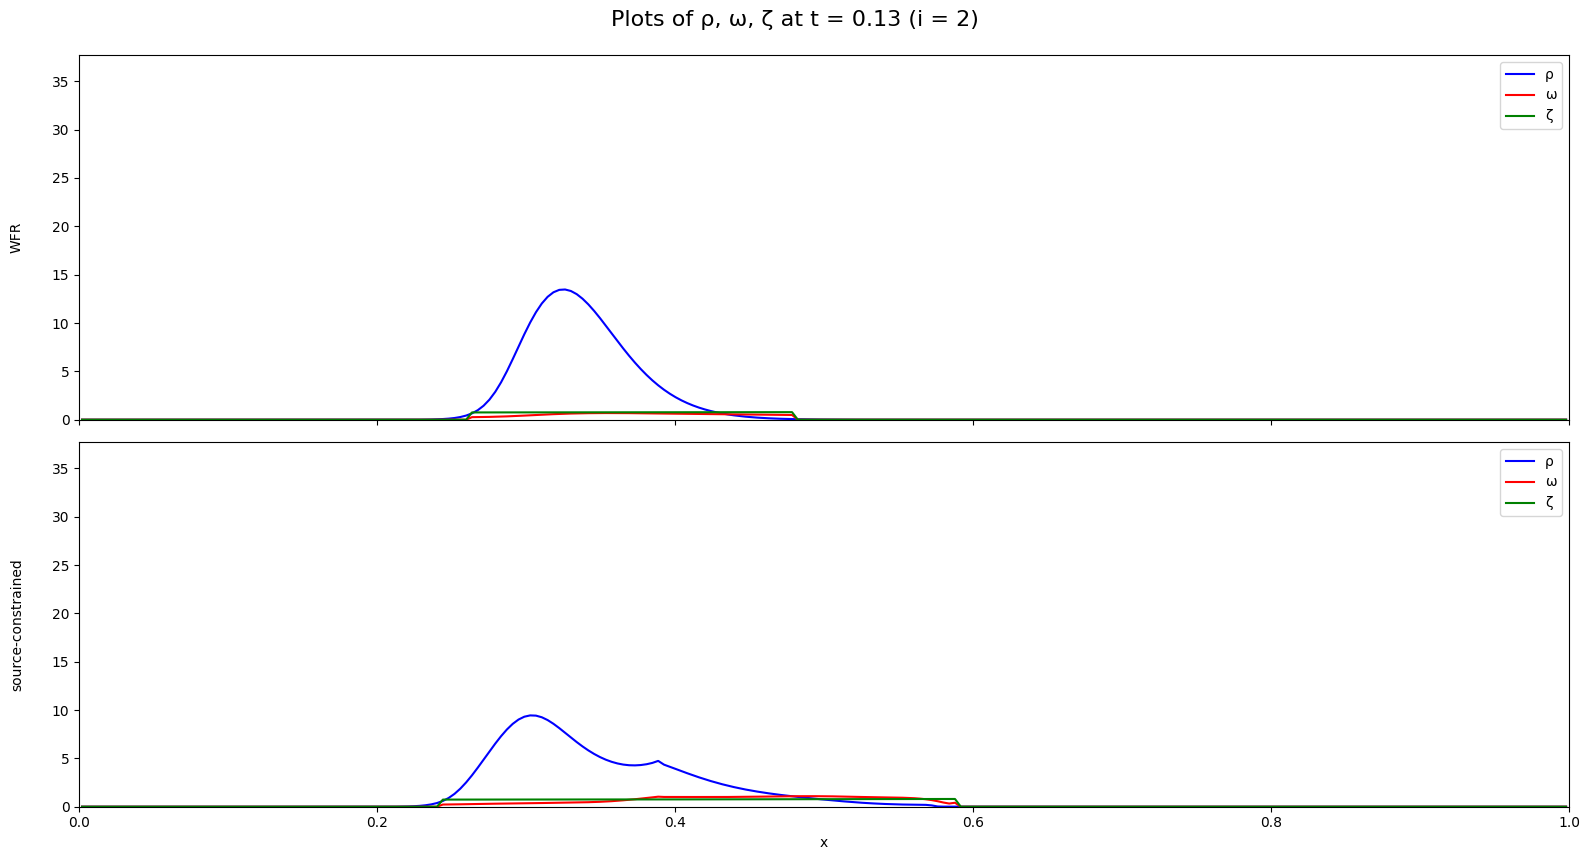

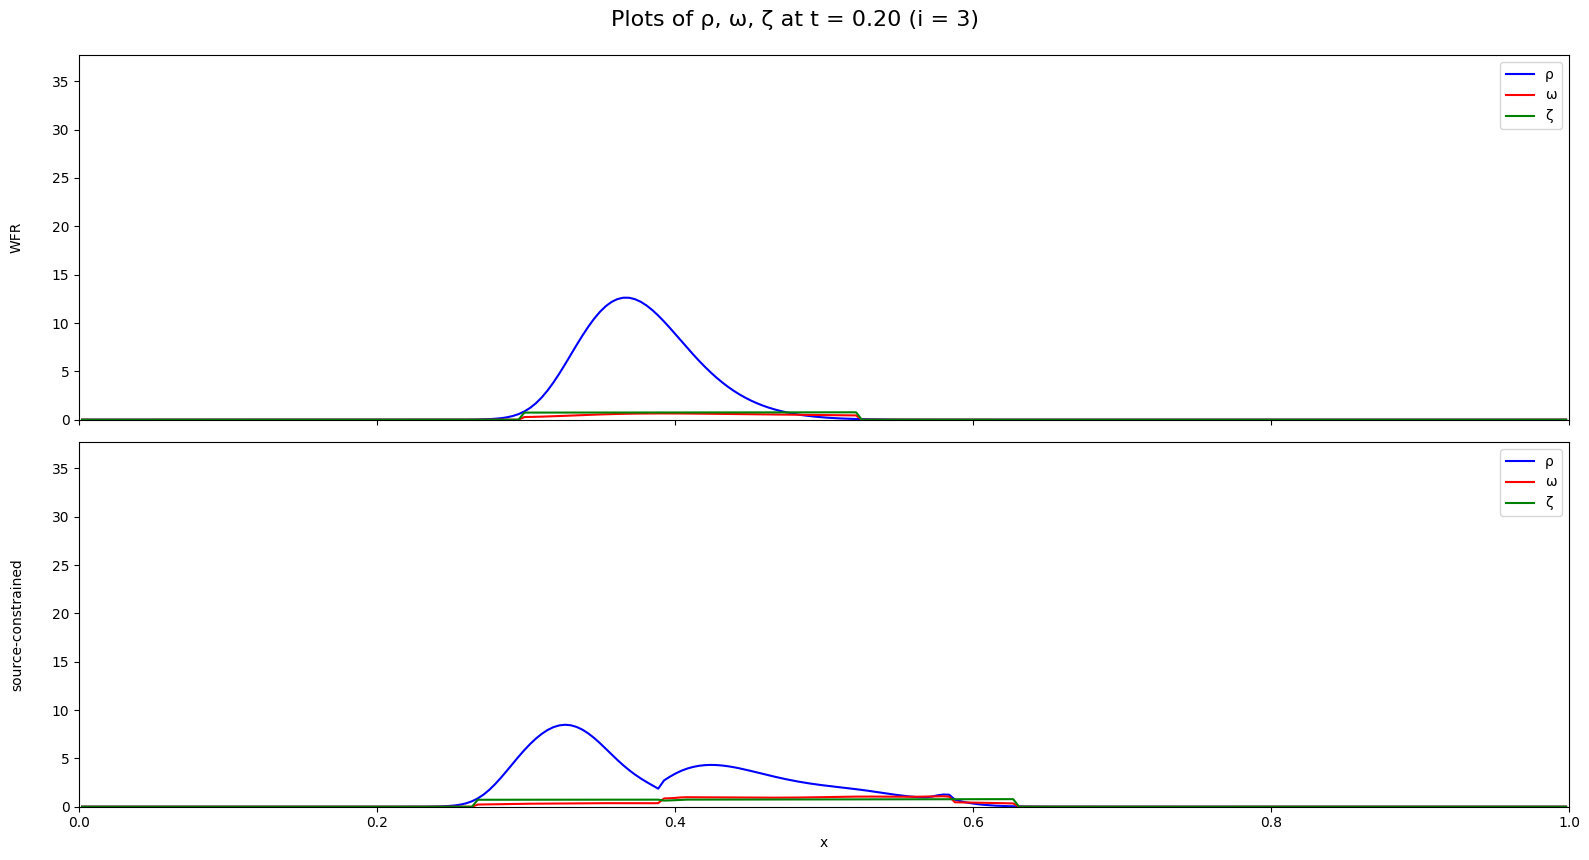

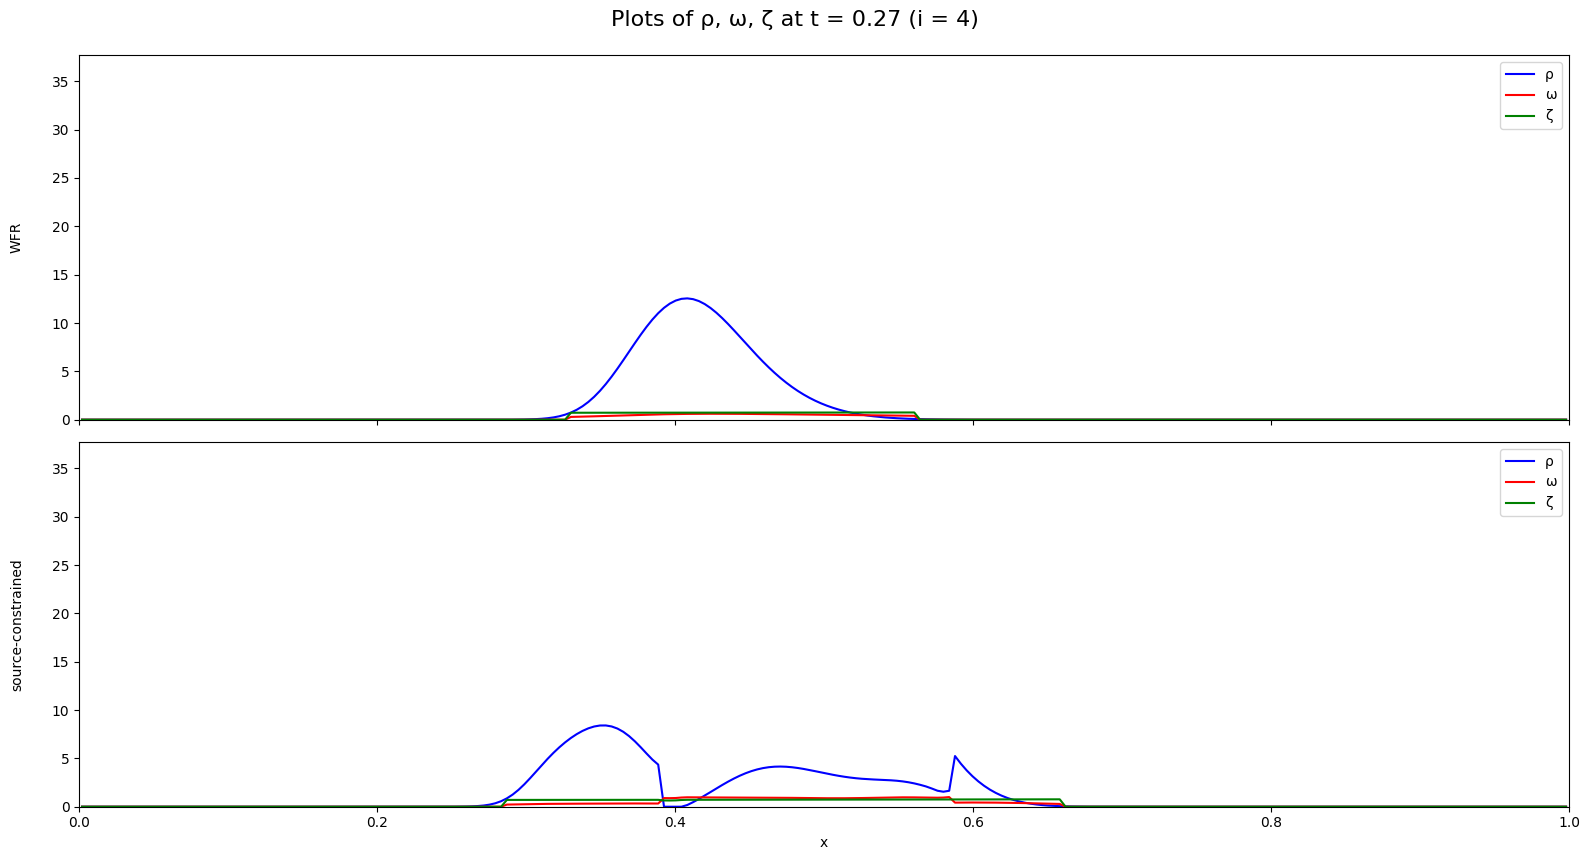

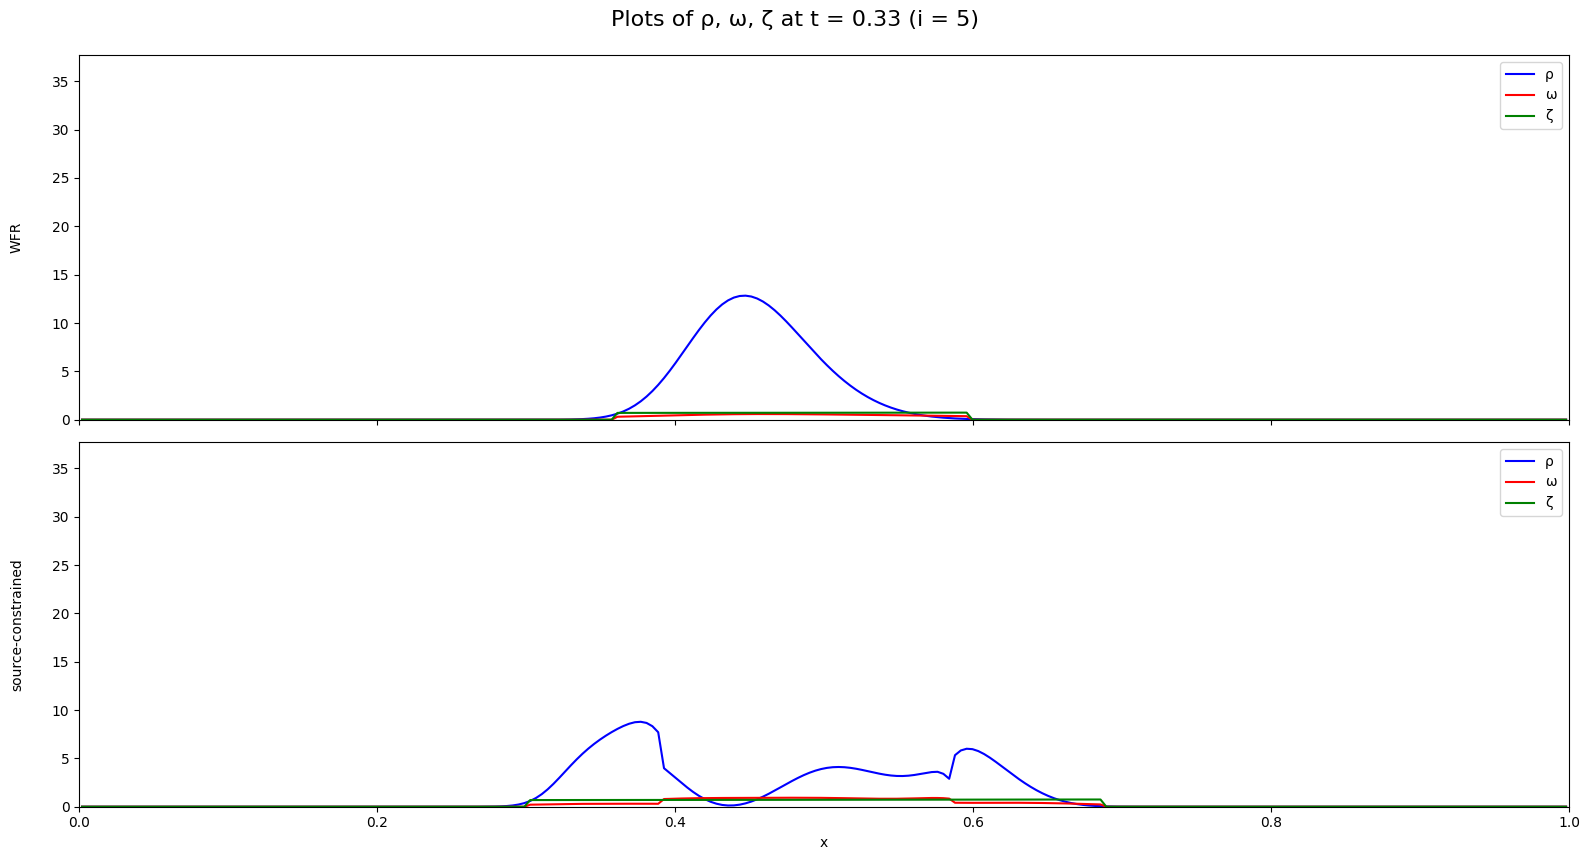

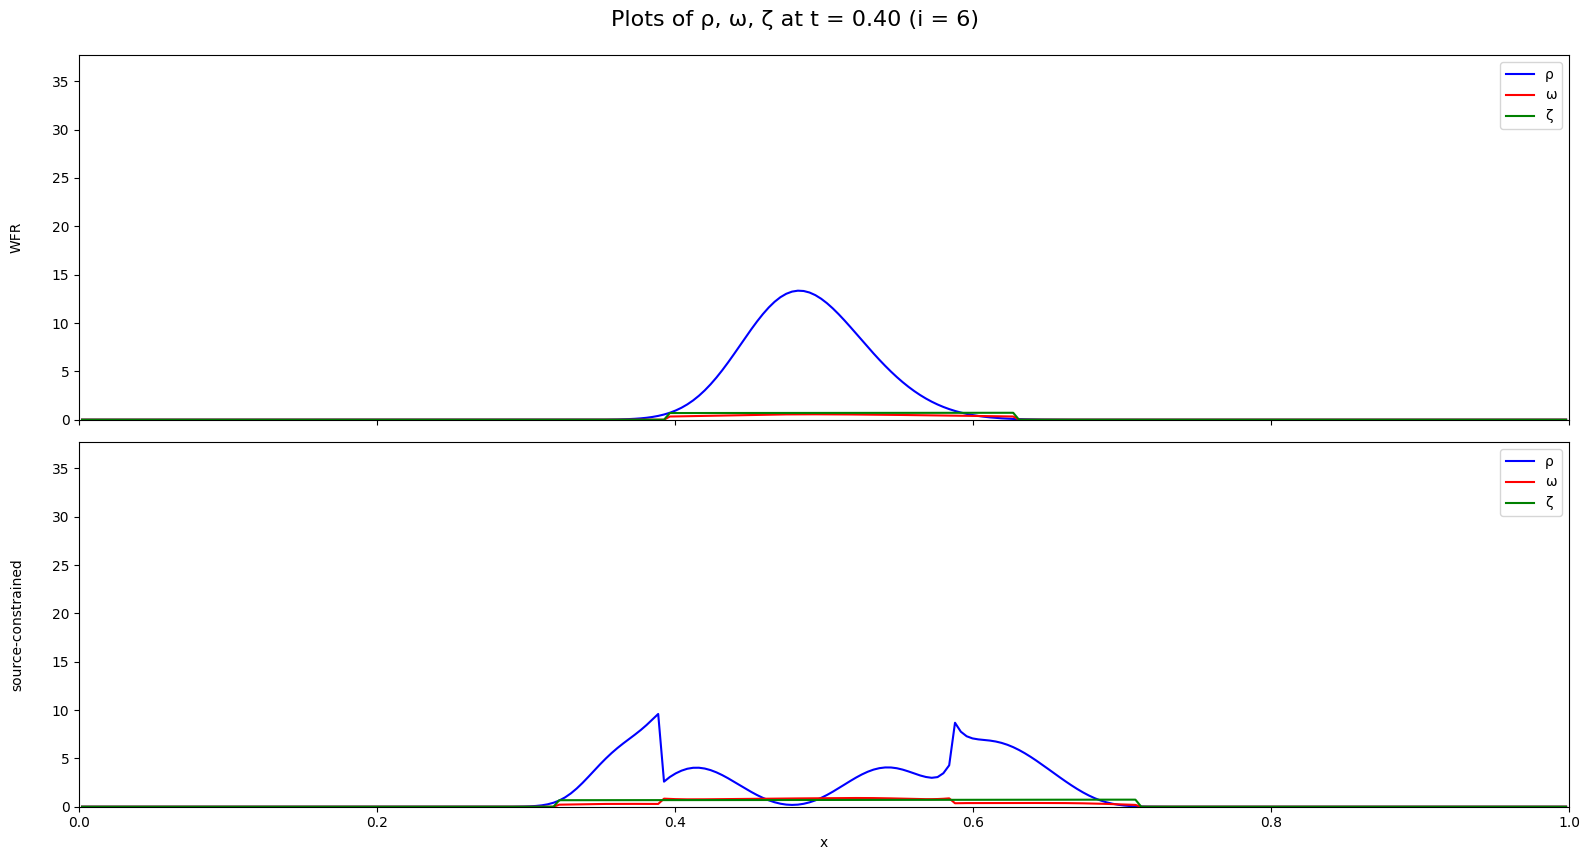

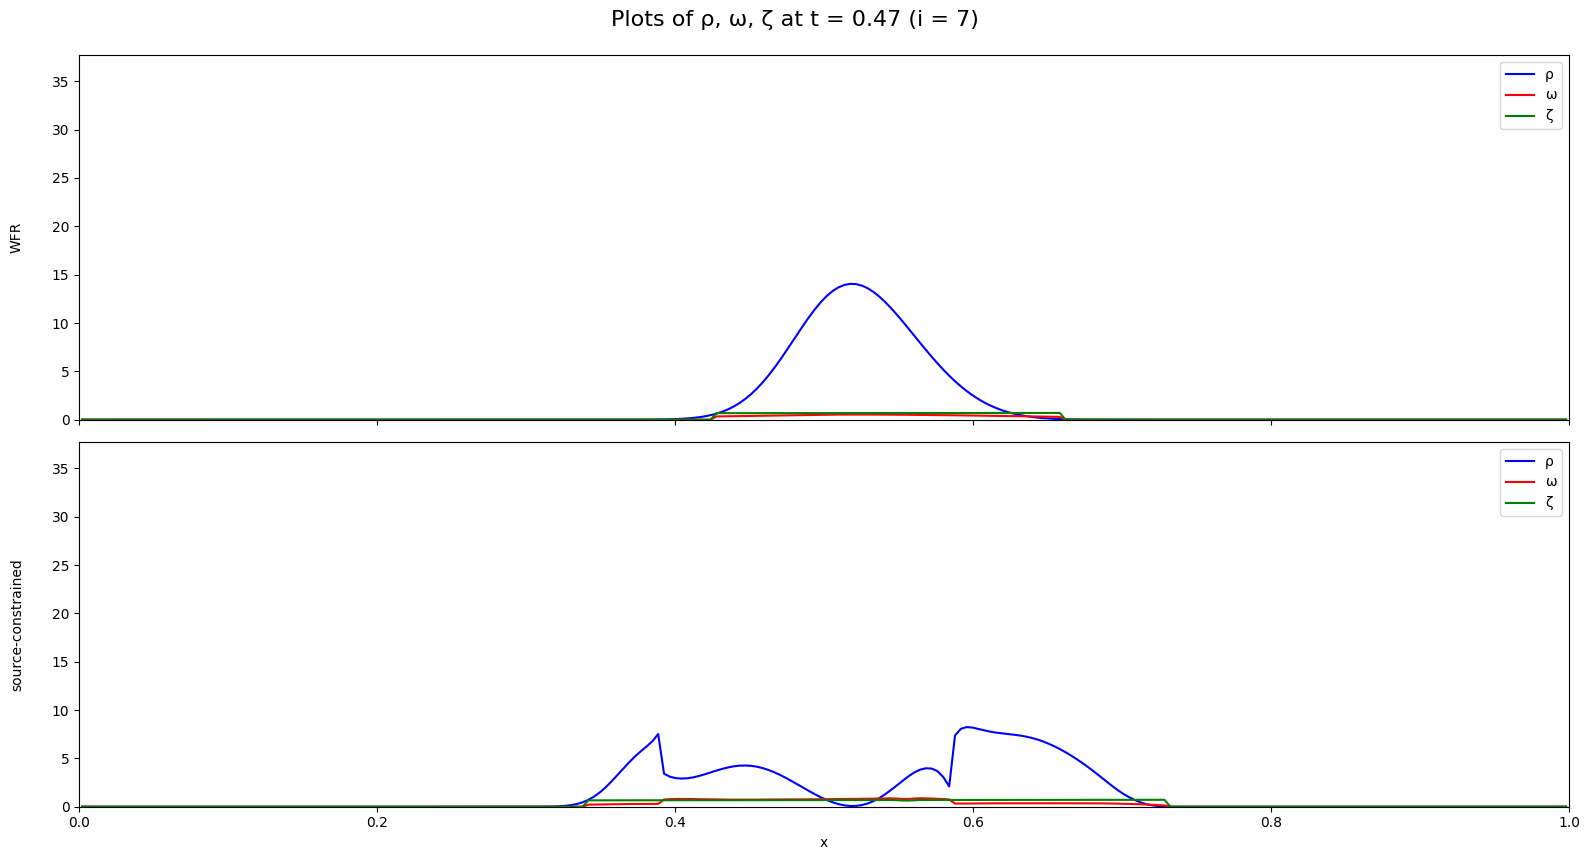

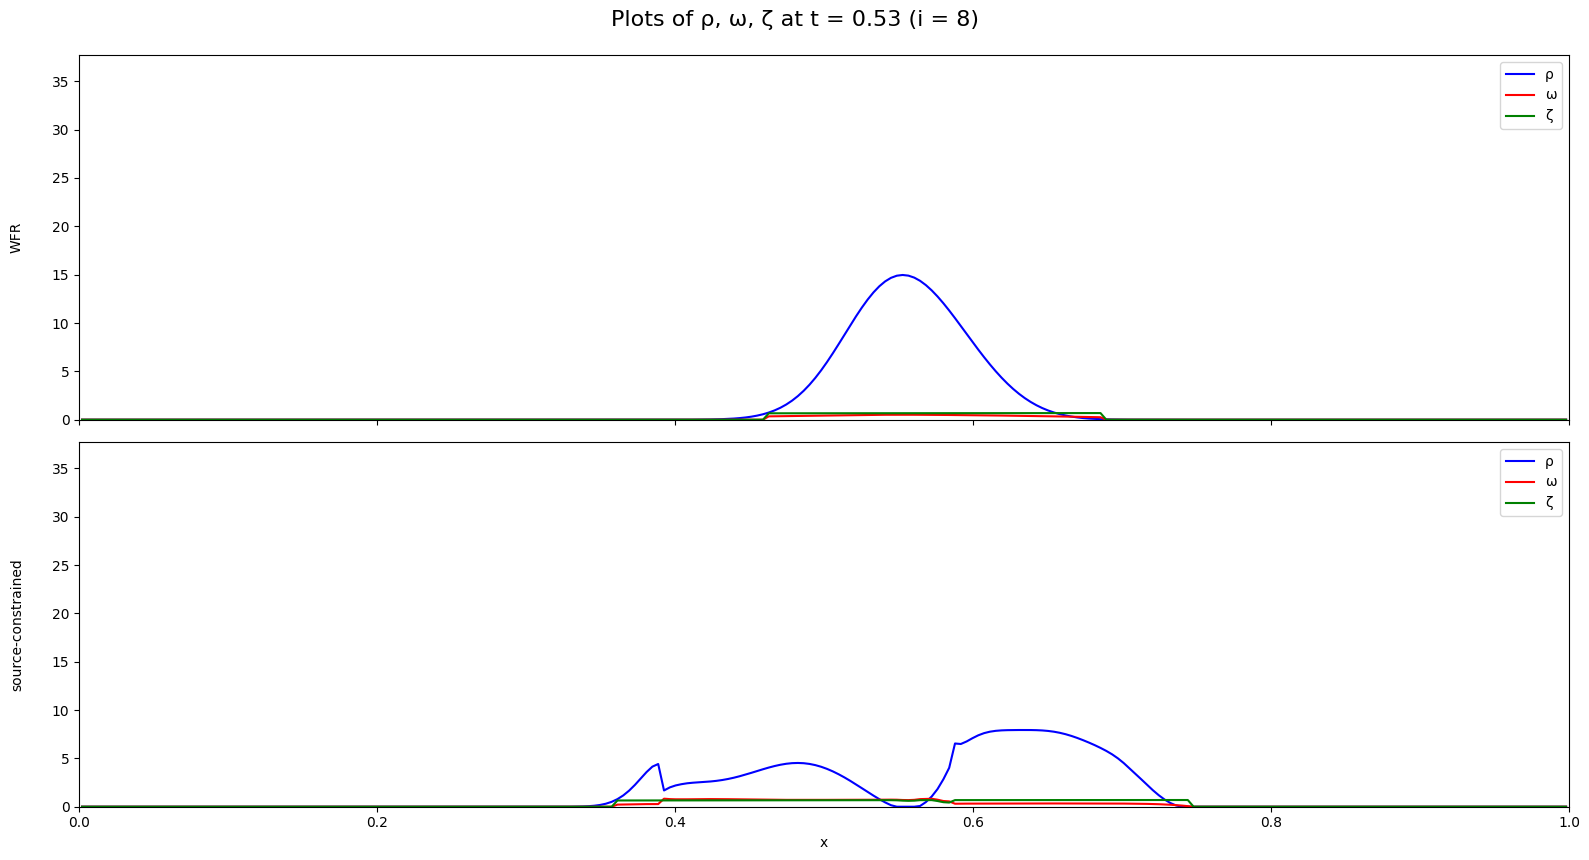

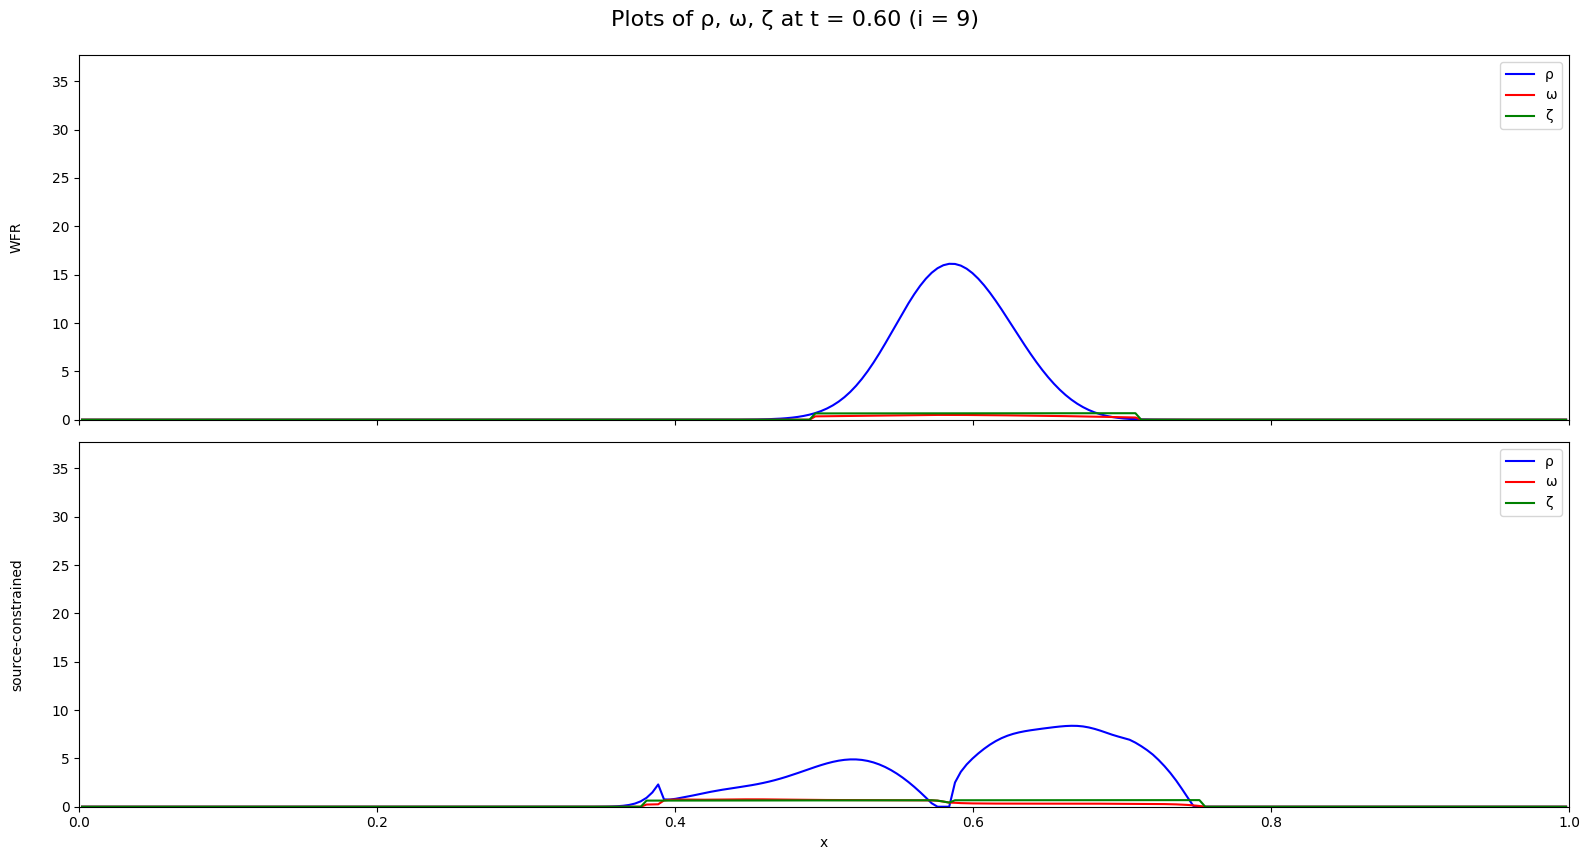

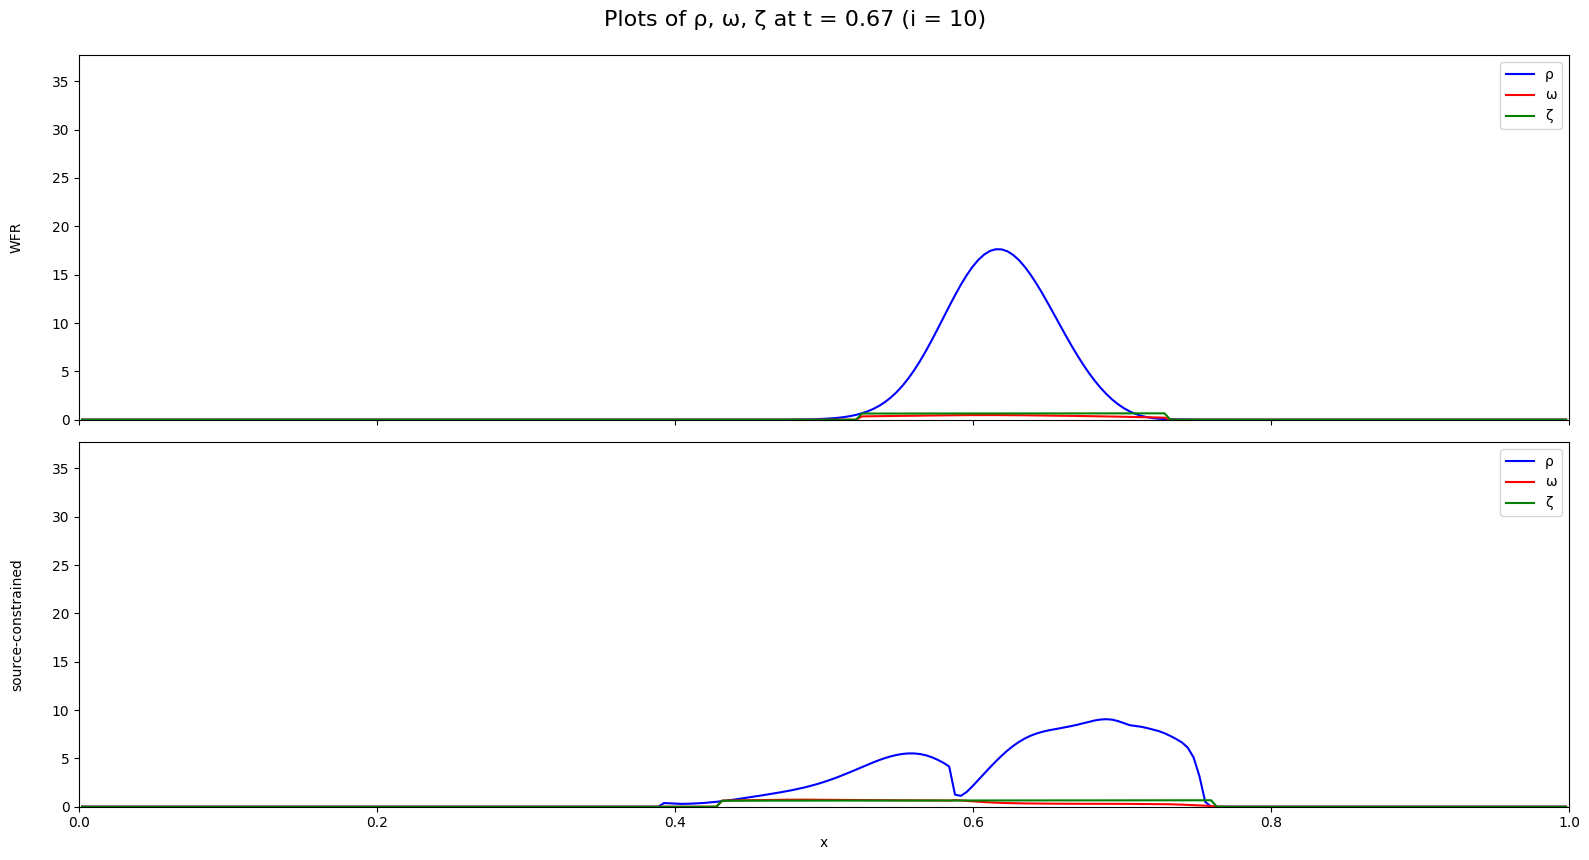

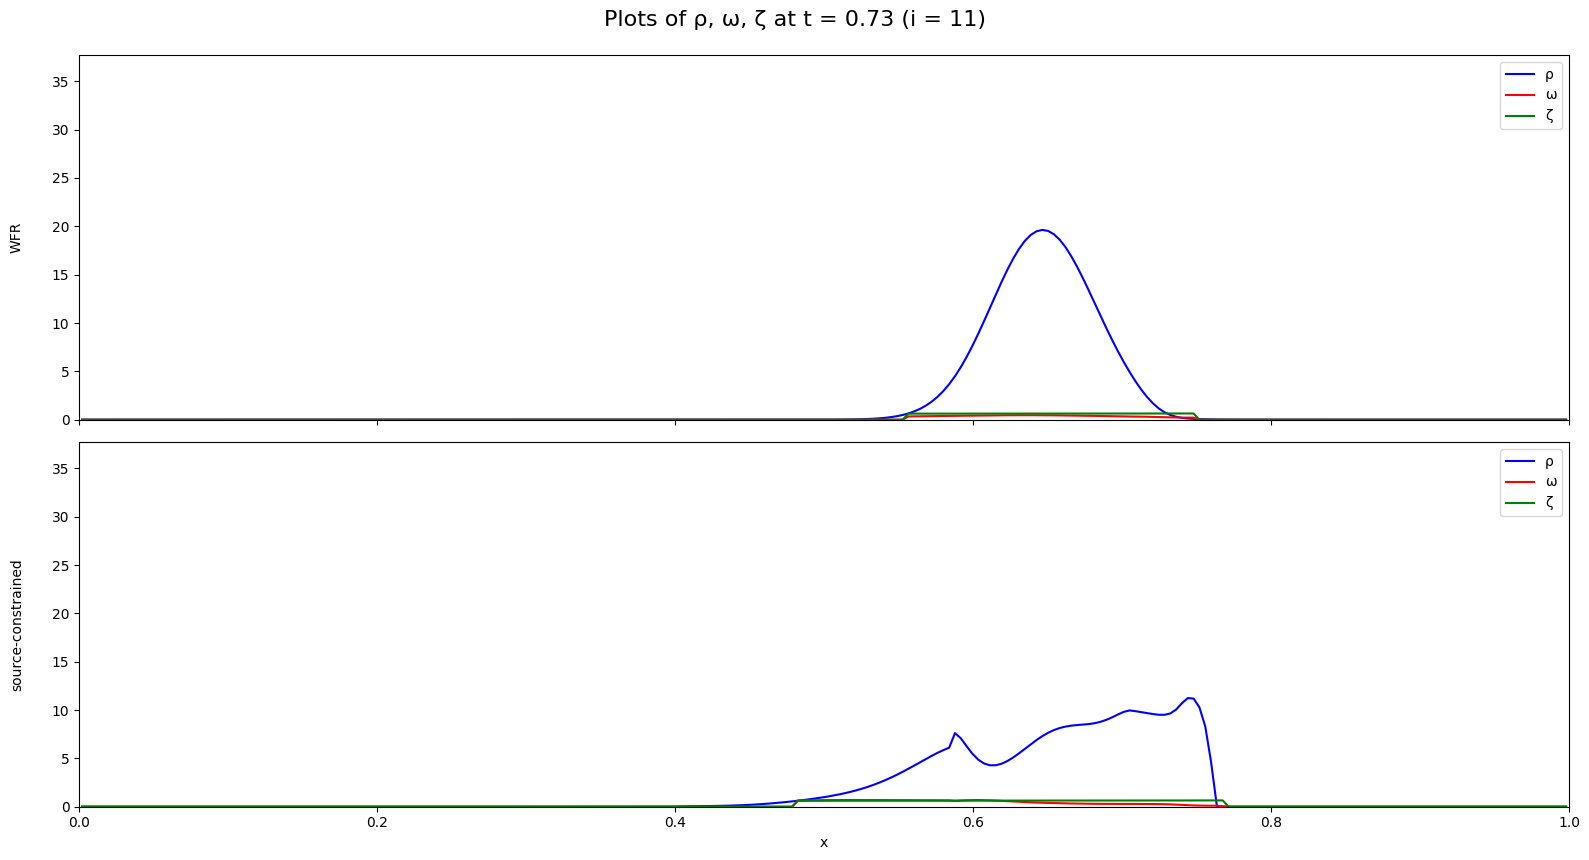

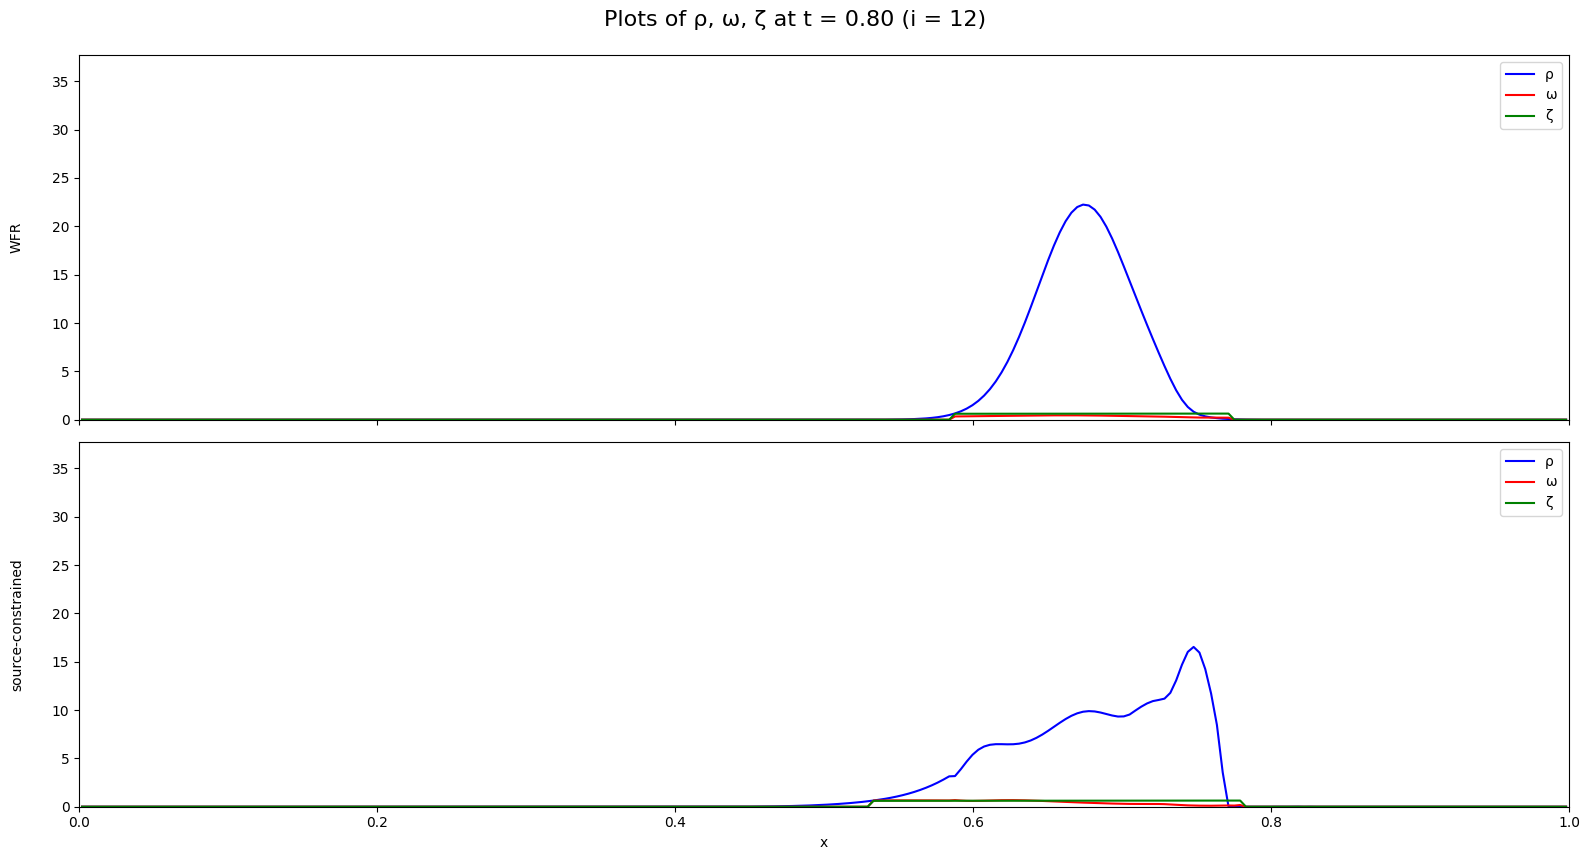

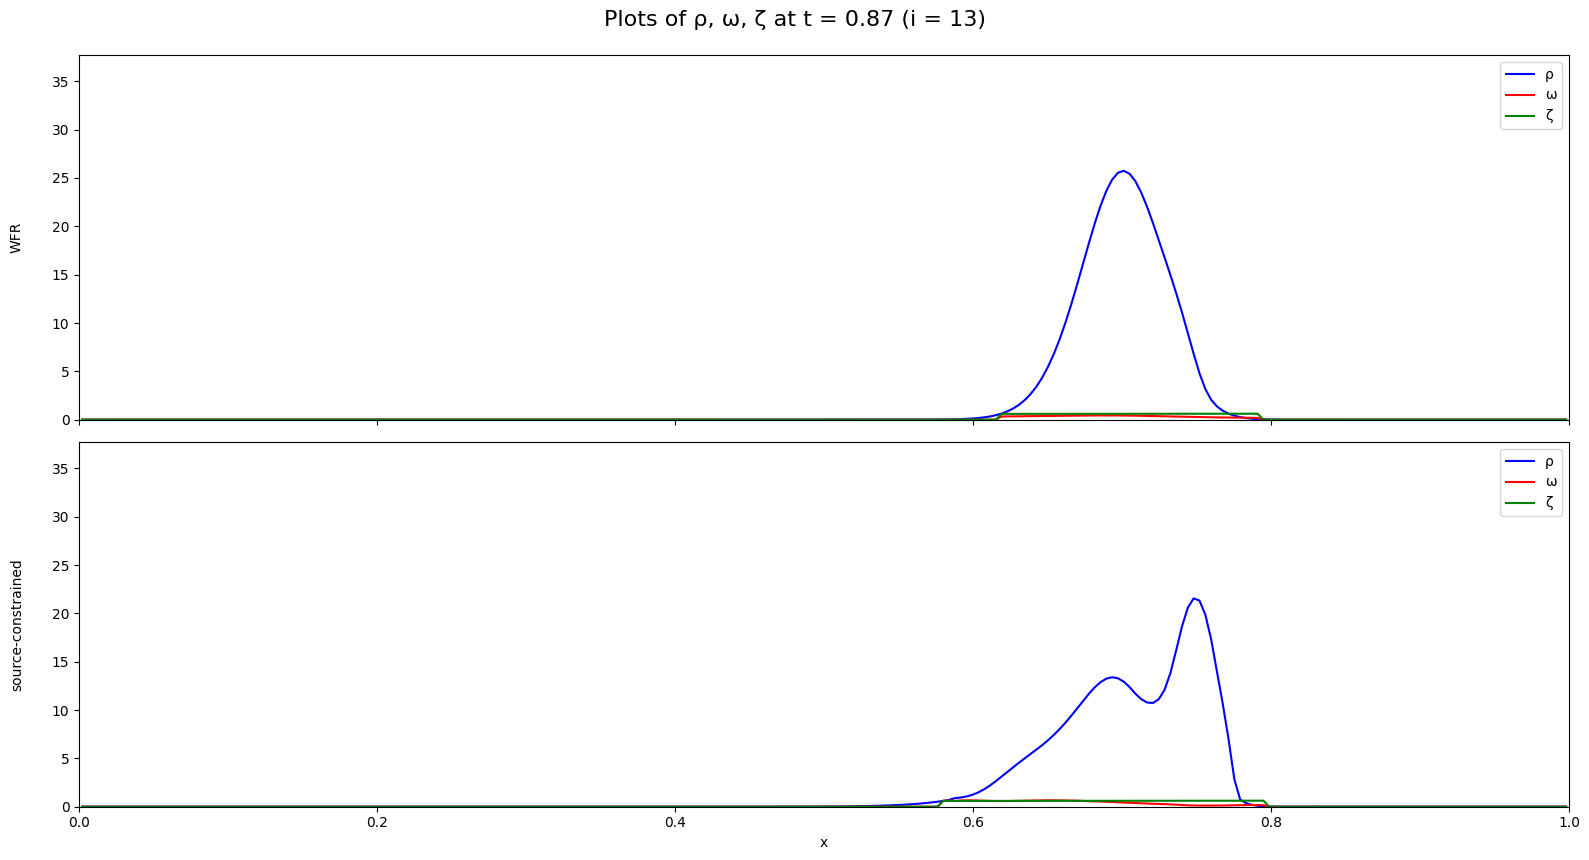

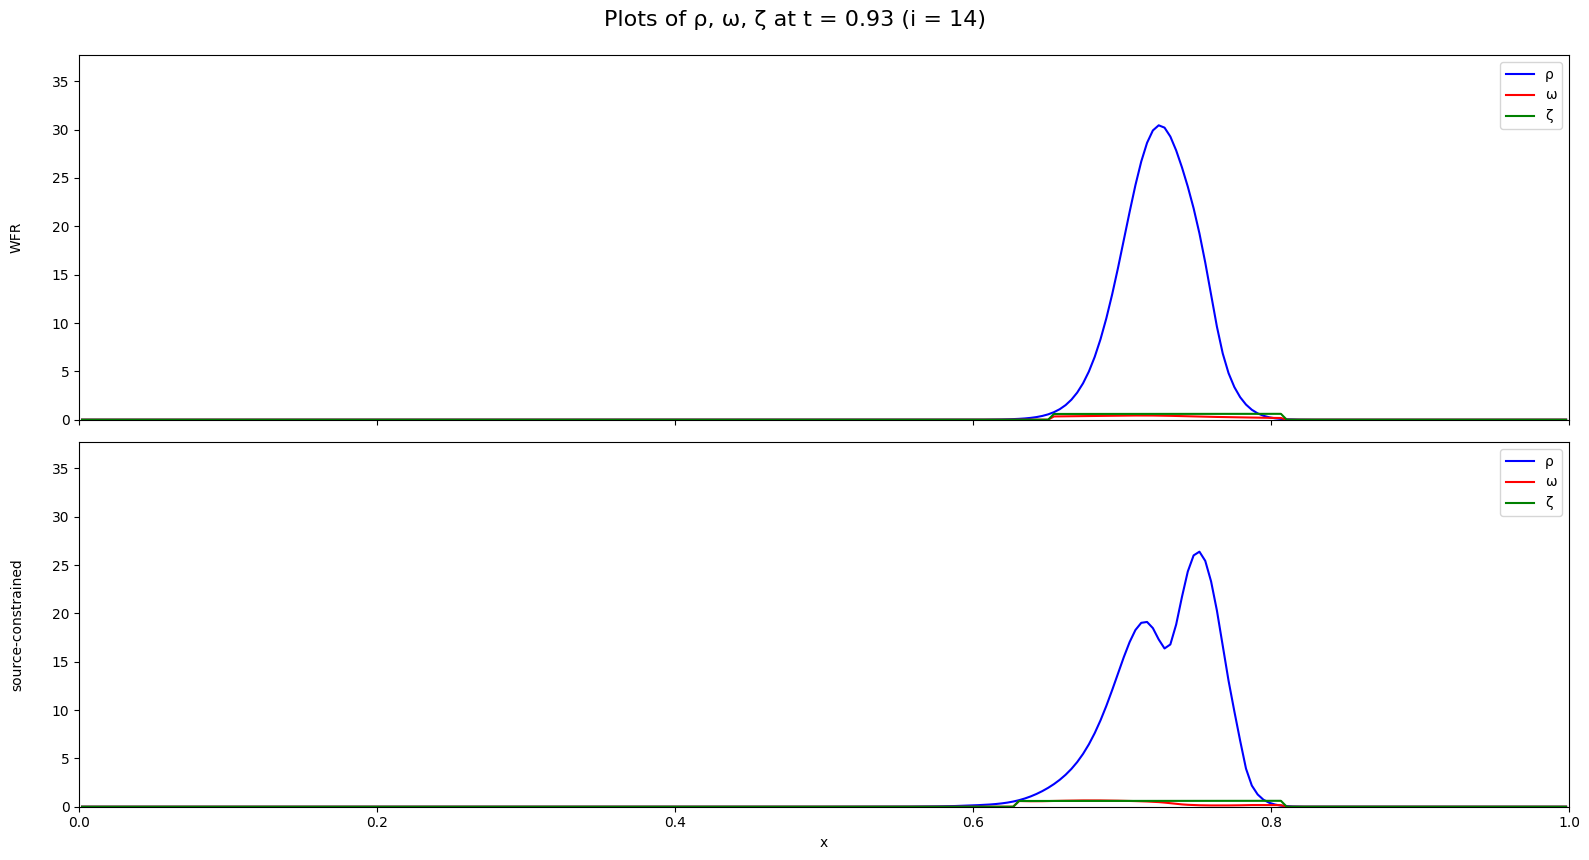

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Ds = []
vs = []
gs = []
for x in xs:
    Ds.append(x.U.D[0])
    v, g = speed_and_growth(x.V, 100)
    vs.append(v[0])
    gs.append(g)

# Time and space grids
t = np.linspace(0, 1, 16)             # t_i = i/15
x_grid = (np.arange(256) + 0.5) / 256 # x_j = (j+0.5)/256

# Row labels
row_labels = ["WFR", "source-constrained"]

# Indices of time to plot
time_indices = list(range(15))

# -----------------------------------------------------------
# 2) Compute global min/max for each row across *all times*
#    and across D, v, and g. This ensures fixed y-limits.
# -----------------------------------------------------------
num_rows = len(row_labels)
min_vals = float('inf')
max_vals = float('-inf')

for row in range(num_rows):
    # Flatten or just use min/max on the entire 16x256 data
    # across D, v, and g for row 'row'
    row_min = min(Ds[row].min(), vs[row].min(), gs[row].min())
    row_max = max(Ds[row].max(), vs[row].max(), gs[row].max())
    
    min_vals = min(row_min, min_vals)
    max_vals = max(row_max, max_vals)

# -----------------------------------------------------------
# 3) Loop through the selected time indices and plot
# -----------------------------------------------------------
for i in time_indices:
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 9), sharex=True)
    
    # Main figure title
    fig.suptitle(f"Plots of ρ, ω, ζ at t = {t[i]:.2f} (i = {i})", fontsize=16, y=0.95)

    for row in range(num_rows):
        ax = axes[row]
        
        # Plot all three on the same axes
        ax.plot(x_grid, Ds[row][i, :], label='ρ', color='blue')
        ax.plot(x_grid, vs[row][i, :], label='ω', color='red')
        ax.plot(x_grid, gs[row][i, :], label='ζ', color='green')
        
        # Set fixed y-limits for this row
        ax.set_ylim([min_vals, max_vals])
        
        # Set x-limits if desired (0 to 1 here)
        ax.set_xlim([0, 1])

        # Label the y-axis to indicate the row
        ax.set_ylabel(row_labels[row], rotation=90, labelpad=20)
        
        # Show legend in each subplot
        ax.legend(loc='best')
    
    # Label the x-axis on the bottom subplot
    axes[-1].set_xlabel("x")
    
    # Final layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

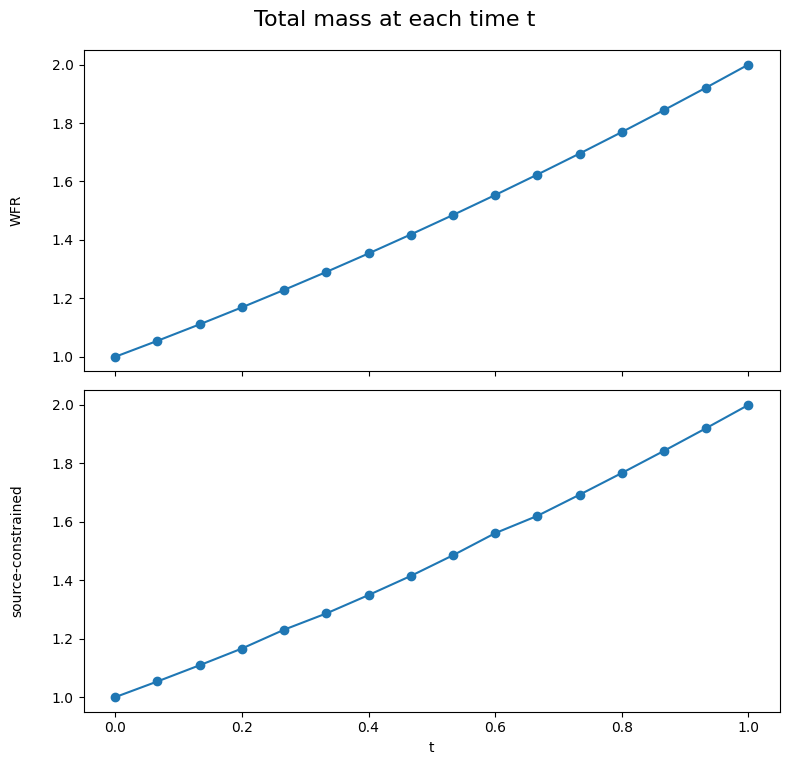

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)

fig.suptitle("Total mass at each time t", fontsize=16, y=0.95)

for row in range(2):
    # sum across columns (axis=1) => shape becomes (16,) for each element
    sum_over_x = np.sum(Ds[row], axis=1) / 256  # sums each row of Ds[row]
    axes[row].plot(t, sum_over_x, marker='o', label="Total mass")
    axes[row].set_ylabel(row_labels[row], rotation=90, labelpad=20)
    
    # Optionally add a legend
    #axes[row].legend(loc='best')

axes[-1].set_xlabel("t")
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()
